# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [16]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

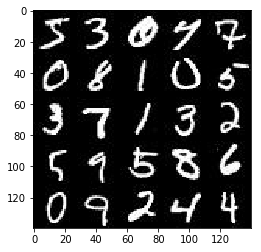

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

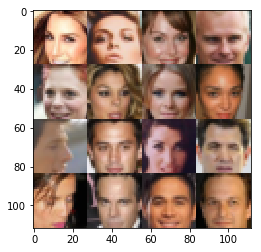

In [19]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0


C:\Users\alceu\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, 
                                shape=(None, image_width, image_height, image_channels), 
                                name='input_real')
    z_input = tf.placeholder(tf.float32, 
                             shape=(None, z_dim), 
                             name='noise_input')
    learn_rate = tf.placeholder(tf.float32, shape=(), name='learn_rate')

    return input_real, z_input, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Input images are either 28x28x3 or 28x28x1.
    with tf.variable_scope('discriminator', reuse=reuse):
        # 1st Convolutional layer.
        conv1 = tf.layers.conv2d(images, 32, 5, 2, padding='same')
        conv1 = tf.maximum(alpha*conv1, conv1) # conv1.shape = (16, 16, 32)
        
        # 2nd Convolutional layer.
        conv2 = tf.layers.conv2d(conv1, 64, 5, 2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2) # conv1.shape = (8, 8, 64)
        
        # 3rd Convolutional layer.
        conv3 = tf.layers.conv2d(conv2, 128, 5, 2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha*conv3, conv3) # conv1.shape = (4, 4, 128)
        
        # Output layer.
        conv3 = tf.reshape(conv3, (-1, 4*4*128)) # Flatten.
        logits = tf.layers.dense(conv3, 1, activation=None)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :re
    turn: The tensor output of the generator
    """
    reuse = False if is_train else True
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z, units=7*7*512)
        x = tf.reshape(x, [-1, 7, 7, 512])
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x) # x.shape = (7, 7, 512)
        
        # 1st Convolution.
        conv1 = tf.layers.conv2d_transpose(x, filters=256, kernel_size=5, 
                                           strides=2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha*conv1, conv1) # conv1.shape = (14, 14, 256)
        
        # Convolution to output.
        logits = tf.layers.conv2d_transpose(conv1, out_channel_dim, 5, 
                                            strides=2, padding='same')
        # logits.shape = (28, 28, out_channel_dim)
        out = 0.5 * tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    input_fake = generator(input_z, out_channel_dim, is_train=True)
    
    _, d_logits_real = discriminator(input_real, reuse=False)
    d_labels_real = tf.ones_like(d_logits_real) * (1.0 - smooth)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=d_labels_real))
    _, d_logits_fake = discriminator(input_fake, reuse=True)
    d_labels_fake = tf.zeros_like(d_logits_fake)
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=d_labels_fake))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [v for v in t_vars if v.name.split('/')[0] == 'generator']
    d_vars = [v for v in t_vars if v.name.split('/')[0] == 'discriminator']

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch_counter = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):                
                
                # Sample random noise for the generator.
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                # Print generator output.
                batch_counter += 1
                if (batch_counter % 100) == 0:
                    show_generator_output(sess, 32, input_z, data_shape[3], data_image_mode)
                    
                # Print losses.
                if (batch_counter % 10) == 0:
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch Count {}...".format(batch_counter),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch Count 10... Discriminator Loss: 0.3497... Generator Loss: 7.8492
Epoch 1/2... Batch Count 20... Discriminator Loss: 0.6228... Generator Loss: 7.9513
Epoch 1/2... Batch Count 30... Discriminator Loss: 0.3421... Generator Loss: 7.6857
Epoch 1/2... Batch Count 40... Discriminator Loss: 0.4325... Generator Loss: 12.6336
Epoch 1/2... Batch Count 50... Discriminator Loss: 0.6529... Generator Loss: 2.6643
Epoch 1/2... Batch Count 60... Discriminator Loss: 0.8592... Generator Loss: 1.1420
Epoch 1/2... Batch Count 70... Discriminator Loss: 0.9531... Generator Loss: 1.1670
Epoch 1/2... Batch Count 80... Discriminator Loss: 0.6549... Generator Loss: 2.0315
Epoch 1/2... Batch Count 90... Discriminator Loss: 0.8187... Generator Loss: 1.3260


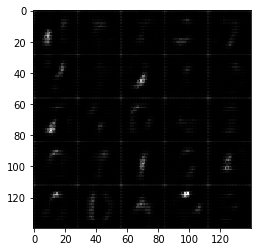

Epoch 1/2... Batch Count 100... Discriminator Loss: 1.2583... Generator Loss: 1.8047
Epoch 1/2... Batch Count 110... Discriminator Loss: 0.7767... Generator Loss: 1.4835
Epoch 1/2... Batch Count 120... Discriminator Loss: 0.9034... Generator Loss: 1.9605
Epoch 1/2... Batch Count 130... Discriminator Loss: 0.7997... Generator Loss: 1.2645
Epoch 1/2... Batch Count 140... Discriminator Loss: 1.0938... Generator Loss: 1.1767
Epoch 1/2... Batch Count 150... Discriminator Loss: 1.8698... Generator Loss: 0.3655
Epoch 1/2... Batch Count 160... Discriminator Loss: 0.6681... Generator Loss: 1.9716
Epoch 1/2... Batch Count 170... Discriminator Loss: 1.3244... Generator Loss: 0.5871
Epoch 1/2... Batch Count 180... Discriminator Loss: 1.0367... Generator Loss: 1.0945
Epoch 1/2... Batch Count 190... Discriminator Loss: 0.8409... Generator Loss: 1.1874


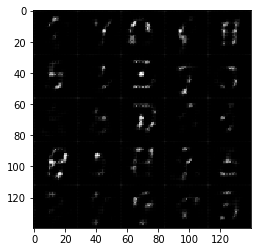

Epoch 1/2... Batch Count 200... Discriminator Loss: 0.9393... Generator Loss: 1.4716
Epoch 1/2... Batch Count 210... Discriminator Loss: 0.9916... Generator Loss: 1.0308
Epoch 1/2... Batch Count 220... Discriminator Loss: 1.1561... Generator Loss: 0.7759
Epoch 1/2... Batch Count 230... Discriminator Loss: 0.9037... Generator Loss: 1.2865
Epoch 1/2... Batch Count 240... Discriminator Loss: 1.1371... Generator Loss: 0.9660
Epoch 1/2... Batch Count 250... Discriminator Loss: 1.3119... Generator Loss: 0.7029
Epoch 1/2... Batch Count 260... Discriminator Loss: 0.9842... Generator Loss: 1.5627
Epoch 1/2... Batch Count 270... Discriminator Loss: 1.3879... Generator Loss: 0.8230
Epoch 1/2... Batch Count 280... Discriminator Loss: 1.3290... Generator Loss: 0.9918
Epoch 1/2... Batch Count 290... Discriminator Loss: 1.4597... Generator Loss: 0.5488


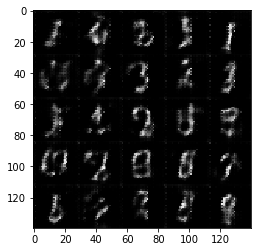

Epoch 1/2... Batch Count 300... Discriminator Loss: 1.0331... Generator Loss: 1.0126
Epoch 1/2... Batch Count 310... Discriminator Loss: 1.1167... Generator Loss: 1.1002
Epoch 1/2... Batch Count 320... Discriminator Loss: 1.1470... Generator Loss: 0.9258
Epoch 1/2... Batch Count 330... Discriminator Loss: 1.1304... Generator Loss: 1.1206
Epoch 1/2... Batch Count 340... Discriminator Loss: 0.9787... Generator Loss: 1.2272
Epoch 1/2... Batch Count 350... Discriminator Loss: 0.9445... Generator Loss: 1.2642
Epoch 1/2... Batch Count 360... Discriminator Loss: 1.2420... Generator Loss: 0.6426
Epoch 1/2... Batch Count 370... Discriminator Loss: 1.0071... Generator Loss: 0.9480
Epoch 1/2... Batch Count 380... Discriminator Loss: 1.1651... Generator Loss: 0.9783
Epoch 1/2... Batch Count 390... Discriminator Loss: 0.7869... Generator Loss: 1.5106


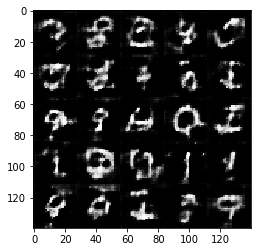

Epoch 1/2... Batch Count 400... Discriminator Loss: 1.0548... Generator Loss: 1.2769
Epoch 1/2... Batch Count 410... Discriminator Loss: 1.7033... Generator Loss: 0.3954
Epoch 1/2... Batch Count 420... Discriminator Loss: 0.9088... Generator Loss: 1.2757
Epoch 1/2... Batch Count 430... Discriminator Loss: 1.2454... Generator Loss: 0.7449
Epoch 1/2... Batch Count 440... Discriminator Loss: 1.2041... Generator Loss: 0.8410
Epoch 1/2... Batch Count 450... Discriminator Loss: 1.2218... Generator Loss: 0.6365
Epoch 1/2... Batch Count 460... Discriminator Loss: 1.2323... Generator Loss: 0.7379
Epoch 1/2... Batch Count 470... Discriminator Loss: 1.0524... Generator Loss: 1.1398
Epoch 1/2... Batch Count 480... Discriminator Loss: 1.1847... Generator Loss: 0.8278
Epoch 1/2... Batch Count 490... Discriminator Loss: 1.3304... Generator Loss: 0.7493


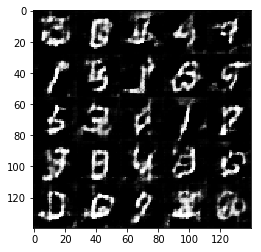

Epoch 1/2... Batch Count 500... Discriminator Loss: 1.0209... Generator Loss: 1.0283
Epoch 1/2... Batch Count 510... Discriminator Loss: 1.0896... Generator Loss: 1.0313
Epoch 1/2... Batch Count 520... Discriminator Loss: 0.8694... Generator Loss: 1.2522
Epoch 1/2... Batch Count 530... Discriminator Loss: 0.9892... Generator Loss: 1.0211
Epoch 1/2... Batch Count 540... Discriminator Loss: 1.2691... Generator Loss: 0.7567
Epoch 1/2... Batch Count 550... Discriminator Loss: 1.0492... Generator Loss: 1.0714
Epoch 1/2... Batch Count 560... Discriminator Loss: 1.2364... Generator Loss: 1.3433
Epoch 1/2... Batch Count 570... Discriminator Loss: 1.1811... Generator Loss: 0.7817
Epoch 1/2... Batch Count 580... Discriminator Loss: 1.0737... Generator Loss: 1.4791
Epoch 1/2... Batch Count 590... Discriminator Loss: 0.9492... Generator Loss: 1.0105


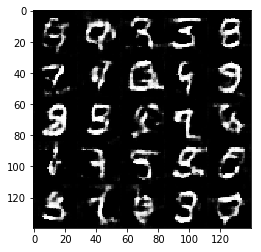

Epoch 1/2... Batch Count 600... Discriminator Loss: 1.2800... Generator Loss: 1.1149
Epoch 1/2... Batch Count 610... Discriminator Loss: 1.0633... Generator Loss: 0.9326
Epoch 1/2... Batch Count 620... Discriminator Loss: 0.9294... Generator Loss: 1.2720
Epoch 1/2... Batch Count 630... Discriminator Loss: 1.3303... Generator Loss: 1.3113
Epoch 1/2... Batch Count 640... Discriminator Loss: 1.0046... Generator Loss: 1.4005
Epoch 1/2... Batch Count 650... Discriminator Loss: 1.2320... Generator Loss: 0.6770
Epoch 1/2... Batch Count 660... Discriminator Loss: 1.1787... Generator Loss: 0.7881
Epoch 1/2... Batch Count 670... Discriminator Loss: 1.1251... Generator Loss: 0.9275
Epoch 1/2... Batch Count 680... Discriminator Loss: 1.0228... Generator Loss: 0.9096
Epoch 1/2... Batch Count 690... Discriminator Loss: 1.5321... Generator Loss: 0.4351


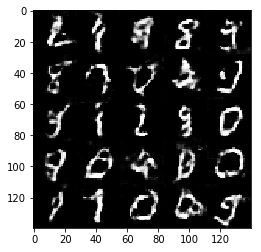

Epoch 1/2... Batch Count 700... Discriminator Loss: 0.9496... Generator Loss: 1.6212
Epoch 1/2... Batch Count 710... Discriminator Loss: 1.1169... Generator Loss: 0.7754
Epoch 1/2... Batch Count 720... Discriminator Loss: 1.1243... Generator Loss: 0.8348
Epoch 1/2... Batch Count 730... Discriminator Loss: 0.9975... Generator Loss: 1.0815
Epoch 1/2... Batch Count 740... Discriminator Loss: 1.1824... Generator Loss: 1.2507
Epoch 1/2... Batch Count 750... Discriminator Loss: 0.8045... Generator Loss: 1.4302
Epoch 1/2... Batch Count 760... Discriminator Loss: 0.8303... Generator Loss: 1.5502
Epoch 1/2... Batch Count 770... Discriminator Loss: 1.1805... Generator Loss: 0.8141
Epoch 1/2... Batch Count 780... Discriminator Loss: 1.1648... Generator Loss: 1.4528
Epoch 1/2... Batch Count 790... Discriminator Loss: 1.0450... Generator Loss: 0.9820


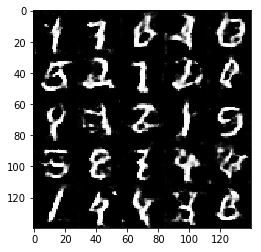

Epoch 1/2... Batch Count 800... Discriminator Loss: 1.4316... Generator Loss: 0.7328
Epoch 1/2... Batch Count 810... Discriminator Loss: 0.9445... Generator Loss: 1.0316
Epoch 1/2... Batch Count 820... Discriminator Loss: 1.0079... Generator Loss: 1.4501
Epoch 1/2... Batch Count 830... Discriminator Loss: 1.0878... Generator Loss: 0.9209
Epoch 1/2... Batch Count 840... Discriminator Loss: 1.1072... Generator Loss: 1.6074
Epoch 1/2... Batch Count 850... Discriminator Loss: 0.8796... Generator Loss: 1.3825
Epoch 1/2... Batch Count 860... Discriminator Loss: 1.0249... Generator Loss: 1.0081
Epoch 1/2... Batch Count 870... Discriminator Loss: 1.0604... Generator Loss: 0.8701
Epoch 1/2... Batch Count 880... Discriminator Loss: 1.5350... Generator Loss: 0.4301
Epoch 1/2... Batch Count 890... Discriminator Loss: 1.2191... Generator Loss: 0.6837


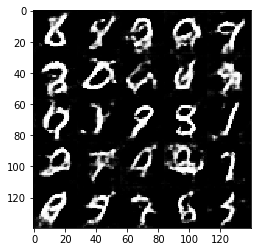

Epoch 1/2... Batch Count 900... Discriminator Loss: 0.8789... Generator Loss: 1.1974
Epoch 1/2... Batch Count 910... Discriminator Loss: 0.9975... Generator Loss: 1.0057
Epoch 1/2... Batch Count 920... Discriminator Loss: 0.9748... Generator Loss: 1.0690
Epoch 1/2... Batch Count 930... Discriminator Loss: 1.1251... Generator Loss: 0.9260
Epoch 1/2... Batch Count 940... Discriminator Loss: 1.1660... Generator Loss: 0.8773
Epoch 1/2... Batch Count 950... Discriminator Loss: 0.9433... Generator Loss: 1.6889
Epoch 1/2... Batch Count 960... Discriminator Loss: 0.9968... Generator Loss: 1.2751
Epoch 1/2... Batch Count 970... Discriminator Loss: 0.9922... Generator Loss: 0.9646
Epoch 1/2... Batch Count 980... Discriminator Loss: 0.9567... Generator Loss: 1.3200
Epoch 1/2... Batch Count 990... Discriminator Loss: 1.0448... Generator Loss: 0.8638


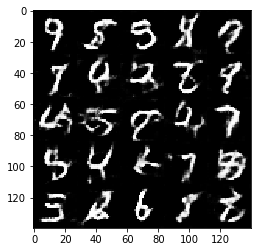

Epoch 1/2... Batch Count 1000... Discriminator Loss: 1.1272... Generator Loss: 0.7292
Epoch 1/2... Batch Count 1010... Discriminator Loss: 1.0641... Generator Loss: 0.8201
Epoch 1/2... Batch Count 1020... Discriminator Loss: 0.8764... Generator Loss: 1.1692
Epoch 1/2... Batch Count 1030... Discriminator Loss: 1.0407... Generator Loss: 1.8856
Epoch 1/2... Batch Count 1040... Discriminator Loss: 1.1286... Generator Loss: 0.9108
Epoch 1/2... Batch Count 1050... Discriminator Loss: 0.8863... Generator Loss: 1.2008
Epoch 1/2... Batch Count 1060... Discriminator Loss: 1.0243... Generator Loss: 0.8821
Epoch 1/2... Batch Count 1070... Discriminator Loss: 1.1931... Generator Loss: 0.7045
Epoch 1/2... Batch Count 1080... Discriminator Loss: 0.9431... Generator Loss: 0.9777
Epoch 1/2... Batch Count 1090... Discriminator Loss: 0.8226... Generator Loss: 1.3647


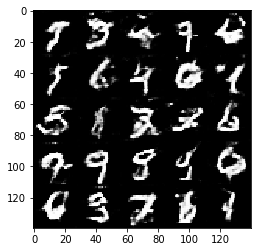

Epoch 1/2... Batch Count 1100... Discriminator Loss: 0.9248... Generator Loss: 1.0778
Epoch 1/2... Batch Count 1110... Discriminator Loss: 1.2624... Generator Loss: 0.7657
Epoch 1/2... Batch Count 1120... Discriminator Loss: 0.9032... Generator Loss: 1.1426
Epoch 1/2... Batch Count 1130... Discriminator Loss: 1.2554... Generator Loss: 0.8532
Epoch 1/2... Batch Count 1140... Discriminator Loss: 1.0880... Generator Loss: 0.8988
Epoch 1/2... Batch Count 1150... Discriminator Loss: 1.1320... Generator Loss: 0.7897
Epoch 1/2... Batch Count 1160... Discriminator Loss: 1.0061... Generator Loss: 1.0446
Epoch 1/2... Batch Count 1170... Discriminator Loss: 0.8952... Generator Loss: 1.2831
Epoch 1/2... Batch Count 1180... Discriminator Loss: 1.1718... Generator Loss: 0.6845
Epoch 1/2... Batch Count 1190... Discriminator Loss: 0.8238... Generator Loss: 1.1964


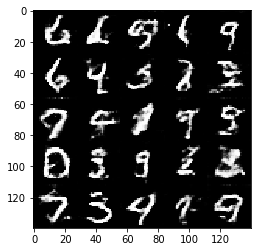

Epoch 1/2... Batch Count 1200... Discriminator Loss: 1.0427... Generator Loss: 0.8315
Epoch 1/2... Batch Count 1210... Discriminator Loss: 1.5426... Generator Loss: 0.4547
Epoch 1/2... Batch Count 1220... Discriminator Loss: 1.0591... Generator Loss: 0.9233
Epoch 1/2... Batch Count 1230... Discriminator Loss: 1.0923... Generator Loss: 0.7696
Epoch 1/2... Batch Count 1240... Discriminator Loss: 0.8314... Generator Loss: 1.2195
Epoch 1/2... Batch Count 1250... Discriminator Loss: 1.0616... Generator Loss: 0.9690
Epoch 1/2... Batch Count 1260... Discriminator Loss: 0.7361... Generator Loss: 1.3998
Epoch 1/2... Batch Count 1270... Discriminator Loss: 1.0472... Generator Loss: 0.8764
Epoch 1/2... Batch Count 1280... Discriminator Loss: 0.6984... Generator Loss: 1.9095
Epoch 1/2... Batch Count 1290... Discriminator Loss: 1.4070... Generator Loss: 0.5724


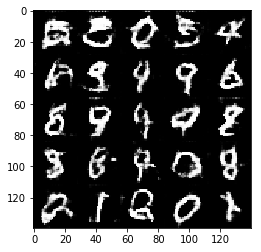

Epoch 1/2... Batch Count 1300... Discriminator Loss: 0.7784... Generator Loss: 1.3633
Epoch 1/2... Batch Count 1310... Discriminator Loss: 0.7988... Generator Loss: 2.4680
Epoch 1/2... Batch Count 1320... Discriminator Loss: 1.6622... Generator Loss: 0.5381
Epoch 1/2... Batch Count 1330... Discriminator Loss: 1.6106... Generator Loss: 0.4838
Epoch 1/2... Batch Count 1340... Discriminator Loss: 1.3644... Generator Loss: 0.5571
Epoch 1/2... Batch Count 1350... Discriminator Loss: 1.2038... Generator Loss: 0.6495
Epoch 1/2... Batch Count 1360... Discriminator Loss: 1.9685... Generator Loss: 0.3155
Epoch 1/2... Batch Count 1370... Discriminator Loss: 0.8589... Generator Loss: 1.3069
Epoch 1/2... Batch Count 1380... Discriminator Loss: 0.8152... Generator Loss: 1.2829
Epoch 1/2... Batch Count 1390... Discriminator Loss: 0.9305... Generator Loss: 1.0172


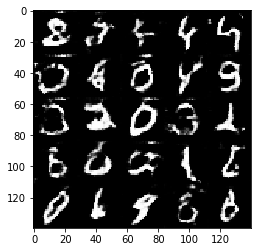

Epoch 1/2... Batch Count 1400... Discriminator Loss: 1.0372... Generator Loss: 0.8664
Epoch 1/2... Batch Count 1410... Discriminator Loss: 1.1326... Generator Loss: 0.7221
Epoch 1/2... Batch Count 1420... Discriminator Loss: 0.8342... Generator Loss: 1.9148
Epoch 1/2... Batch Count 1430... Discriminator Loss: 1.2345... Generator Loss: 1.2847
Epoch 1/2... Batch Count 1440... Discriminator Loss: 0.7650... Generator Loss: 1.7924
Epoch 1/2... Batch Count 1450... Discriminator Loss: 0.8150... Generator Loss: 1.1289
Epoch 1/2... Batch Count 1460... Discriminator Loss: 0.8236... Generator Loss: 1.2144
Epoch 1/2... Batch Count 1470... Discriminator Loss: 1.2621... Generator Loss: 0.6698
Epoch 1/2... Batch Count 1480... Discriminator Loss: 0.6698... Generator Loss: 1.5972
Epoch 1/2... Batch Count 1490... Discriminator Loss: 0.9577... Generator Loss: 0.9485


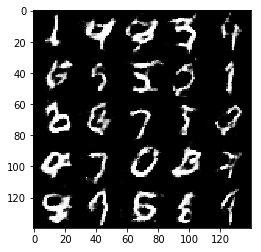

Epoch 1/2... Batch Count 1500... Discriminator Loss: 0.8224... Generator Loss: 1.8408
Epoch 1/2... Batch Count 1510... Discriminator Loss: 1.5899... Generator Loss: 0.3923
Epoch 1/2... Batch Count 1520... Discriminator Loss: 0.6936... Generator Loss: 1.5268
Epoch 1/2... Batch Count 1530... Discriminator Loss: 1.2553... Generator Loss: 0.7187
Epoch 1/2... Batch Count 1540... Discriminator Loss: 0.7525... Generator Loss: 1.5752
Epoch 1/2... Batch Count 1550... Discriminator Loss: 0.7489... Generator Loss: 1.4336
Epoch 1/2... Batch Count 1560... Discriminator Loss: 1.0355... Generator Loss: 0.9120
Epoch 1/2... Batch Count 1570... Discriminator Loss: 0.7974... Generator Loss: 1.4790
Epoch 1/2... Batch Count 1580... Discriminator Loss: 0.9126... Generator Loss: 1.1615
Epoch 1/2... Batch Count 1590... Discriminator Loss: 0.8099... Generator Loss: 1.2047


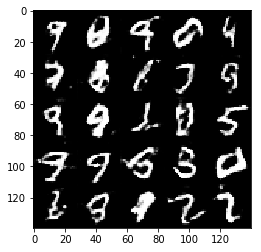

Epoch 1/2... Batch Count 1600... Discriminator Loss: 1.2505... Generator Loss: 0.6293
Epoch 1/2... Batch Count 1610... Discriminator Loss: 1.1440... Generator Loss: 0.8826
Epoch 1/2... Batch Count 1620... Discriminator Loss: 1.0934... Generator Loss: 0.7978
Epoch 1/2... Batch Count 1630... Discriminator Loss: 0.9981... Generator Loss: 1.9780
Epoch 1/2... Batch Count 1640... Discriminator Loss: 1.2139... Generator Loss: 0.6407
Epoch 1/2... Batch Count 1650... Discriminator Loss: 0.5933... Generator Loss: 1.8982
Epoch 1/2... Batch Count 1660... Discriminator Loss: 0.7053... Generator Loss: 1.7193
Epoch 1/2... Batch Count 1670... Discriminator Loss: 1.1094... Generator Loss: 0.7659
Epoch 1/2... Batch Count 1680... Discriminator Loss: 0.6042... Generator Loss: 2.2125
Epoch 1/2... Batch Count 1690... Discriminator Loss: 0.8776... Generator Loss: 1.2289


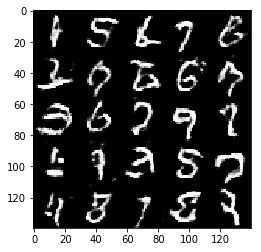

Epoch 1/2... Batch Count 1700... Discriminator Loss: 1.3308... Generator Loss: 0.6442
Epoch 1/2... Batch Count 1710... Discriminator Loss: 0.7294... Generator Loss: 1.8645
Epoch 1/2... Batch Count 1720... Discriminator Loss: 0.9180... Generator Loss: 1.7186
Epoch 1/2... Batch Count 1730... Discriminator Loss: 1.5431... Generator Loss: 0.6240
Epoch 1/2... Batch Count 1740... Discriminator Loss: 1.0641... Generator Loss: 1.0065
Epoch 1/2... Batch Count 1750... Discriminator Loss: 1.0002... Generator Loss: 0.9705
Epoch 1/2... Batch Count 1760... Discriminator Loss: 1.1302... Generator Loss: 0.7223
Epoch 1/2... Batch Count 1770... Discriminator Loss: 0.7719... Generator Loss: 1.3767
Epoch 1/2... Batch Count 1780... Discriminator Loss: 1.0331... Generator Loss: 0.8642
Epoch 1/2... Batch Count 1790... Discriminator Loss: 0.6729... Generator Loss: 1.7062


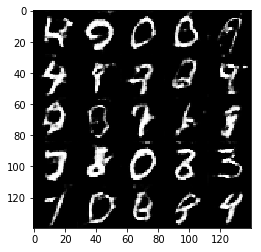

Epoch 1/2... Batch Count 1800... Discriminator Loss: 0.8138... Generator Loss: 1.6308
Epoch 1/2... Batch Count 1810... Discriminator Loss: 0.6847... Generator Loss: 1.4134
Epoch 1/2... Batch Count 1820... Discriminator Loss: 0.7718... Generator Loss: 1.3315
Epoch 1/2... Batch Count 1830... Discriminator Loss: 0.9902... Generator Loss: 0.9466
Epoch 1/2... Batch Count 1840... Discriminator Loss: 0.7163... Generator Loss: 1.4405
Epoch 1/2... Batch Count 1850... Discriminator Loss: 1.8657... Generator Loss: 0.3789
Epoch 1/2... Batch Count 1860... Discriminator Loss: 1.2144... Generator Loss: 0.6804
Epoch 1/2... Batch Count 1870... Discriminator Loss: 0.5753... Generator Loss: 1.8737
Epoch 2/2... Batch Count 1880... Discriminator Loss: 0.7158... Generator Loss: 1.4102
Epoch 2/2... Batch Count 1890... Discriminator Loss: 0.7056... Generator Loss: 2.0245


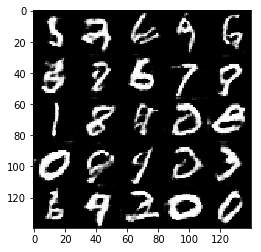

Epoch 2/2... Batch Count 1900... Discriminator Loss: 0.6837... Generator Loss: 1.7049
Epoch 2/2... Batch Count 1910... Discriminator Loss: 0.9237... Generator Loss: 1.0617
Epoch 2/2... Batch Count 1920... Discriminator Loss: 0.9564... Generator Loss: 0.9082
Epoch 2/2... Batch Count 1930... Discriminator Loss: 1.3465... Generator Loss: 0.6784
Epoch 2/2... Batch Count 1940... Discriminator Loss: 1.0278... Generator Loss: 0.9672
Epoch 2/2... Batch Count 1950... Discriminator Loss: 0.6889... Generator Loss: 1.4766
Epoch 2/2... Batch Count 1960... Discriminator Loss: 0.7628... Generator Loss: 1.3033
Epoch 2/2... Batch Count 1970... Discriminator Loss: 1.7292... Generator Loss: 0.3758
Epoch 2/2... Batch Count 1980... Discriminator Loss: 1.2208... Generator Loss: 0.8061
Epoch 2/2... Batch Count 1990... Discriminator Loss: 0.8660... Generator Loss: 1.0493


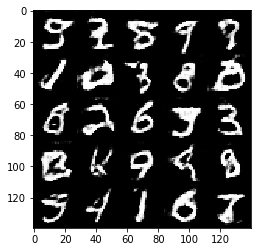

Epoch 2/2... Batch Count 2000... Discriminator Loss: 0.7359... Generator Loss: 1.3706
Epoch 2/2... Batch Count 2010... Discriminator Loss: 0.9529... Generator Loss: 1.1181
Epoch 2/2... Batch Count 2020... Discriminator Loss: 0.9159... Generator Loss: 1.0839
Epoch 2/2... Batch Count 2030... Discriminator Loss: 0.8851... Generator Loss: 1.2049
Epoch 2/2... Batch Count 2040... Discriminator Loss: 0.8083... Generator Loss: 1.1766
Epoch 2/2... Batch Count 2050... Discriminator Loss: 0.8795... Generator Loss: 1.2332
Epoch 2/2... Batch Count 2060... Discriminator Loss: 0.6703... Generator Loss: 1.4761
Epoch 2/2... Batch Count 2070... Discriminator Loss: 0.5949... Generator Loss: 1.8357
Epoch 2/2... Batch Count 2080... Discriminator Loss: 0.9603... Generator Loss: 0.9226
Epoch 2/2... Batch Count 2090... Discriminator Loss: 0.7810... Generator Loss: 1.4115


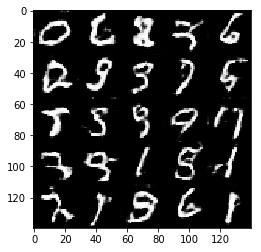

Epoch 2/2... Batch Count 2100... Discriminator Loss: 0.8315... Generator Loss: 1.2559
Epoch 2/2... Batch Count 2110... Discriminator Loss: 0.7472... Generator Loss: 1.4824
Epoch 2/2... Batch Count 2120... Discriminator Loss: 0.9285... Generator Loss: 1.0775
Epoch 2/2... Batch Count 2130... Discriminator Loss: 0.5921... Generator Loss: 1.8148
Epoch 2/2... Batch Count 2140... Discriminator Loss: 1.0420... Generator Loss: 0.8138
Epoch 2/2... Batch Count 2150... Discriminator Loss: 0.6537... Generator Loss: 1.6165
Epoch 2/2... Batch Count 2160... Discriminator Loss: 1.0187... Generator Loss: 0.8328
Epoch 2/2... Batch Count 2170... Discriminator Loss: 0.8829... Generator Loss: 2.0390
Epoch 2/2... Batch Count 2180... Discriminator Loss: 0.7911... Generator Loss: 1.3785
Epoch 2/2... Batch Count 2190... Discriminator Loss: 0.5427... Generator Loss: 2.3145


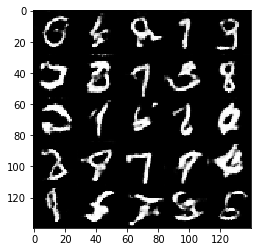

Epoch 2/2... Batch Count 2200... Discriminator Loss: 1.0661... Generator Loss: 0.8971
Epoch 2/2... Batch Count 2210... Discriminator Loss: 0.7187... Generator Loss: 1.7407
Epoch 2/2... Batch Count 2220... Discriminator Loss: 0.6539... Generator Loss: 1.6421
Epoch 2/2... Batch Count 2230... Discriminator Loss: 0.6815... Generator Loss: 1.6543
Epoch 2/2... Batch Count 2240... Discriminator Loss: 0.7203... Generator Loss: 1.5179
Epoch 2/2... Batch Count 2250... Discriminator Loss: 0.7647... Generator Loss: 1.3837
Epoch 2/2... Batch Count 2260... Discriminator Loss: 0.6742... Generator Loss: 1.4843
Epoch 2/2... Batch Count 2270... Discriminator Loss: 0.7885... Generator Loss: 1.9105
Epoch 2/2... Batch Count 2280... Discriminator Loss: 0.5280... Generator Loss: 2.0903
Epoch 2/2... Batch Count 2290... Discriminator Loss: 2.1151... Generator Loss: 0.3340


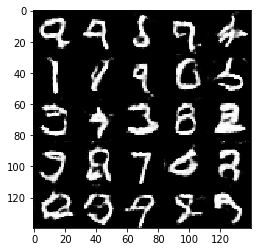

Epoch 2/2... Batch Count 2300... Discriminator Loss: 0.8054... Generator Loss: 1.3212
Epoch 2/2... Batch Count 2310... Discriminator Loss: 0.7610... Generator Loss: 1.5575
Epoch 2/2... Batch Count 2320... Discriminator Loss: 0.7910... Generator Loss: 1.6219
Epoch 2/2... Batch Count 2330... Discriminator Loss: 0.9421... Generator Loss: 1.1108
Epoch 2/2... Batch Count 2340... Discriminator Loss: 0.9466... Generator Loss: 1.2268
Epoch 2/2... Batch Count 2350... Discriminator Loss: 0.6386... Generator Loss: 1.5981
Epoch 2/2... Batch Count 2360... Discriminator Loss: 0.9246... Generator Loss: 1.1624
Epoch 2/2... Batch Count 2370... Discriminator Loss: 0.7308... Generator Loss: 1.4587
Epoch 2/2... Batch Count 2380... Discriminator Loss: 1.0845... Generator Loss: 0.8037
Epoch 2/2... Batch Count 2390... Discriminator Loss: 0.6214... Generator Loss: 1.8129


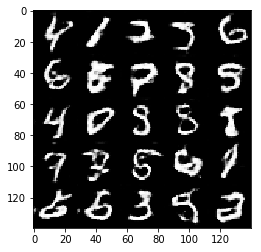

Epoch 2/2... Batch Count 2400... Discriminator Loss: 1.1594... Generator Loss: 0.7476
Epoch 2/2... Batch Count 2410... Discriminator Loss: 1.2305... Generator Loss: 0.7229
Epoch 2/2... Batch Count 2420... Discriminator Loss: 0.8903... Generator Loss: 1.0424
Epoch 2/2... Batch Count 2430... Discriminator Loss: 0.6282... Generator Loss: 1.8932
Epoch 2/2... Batch Count 2440... Discriminator Loss: 0.7764... Generator Loss: 1.7867
Epoch 2/2... Batch Count 2450... Discriminator Loss: 0.9812... Generator Loss: 1.0418
Epoch 2/2... Batch Count 2460... Discriminator Loss: 0.6591... Generator Loss: 1.6446
Epoch 2/2... Batch Count 2470... Discriminator Loss: 1.0227... Generator Loss: 0.9814
Epoch 2/2... Batch Count 2480... Discriminator Loss: 0.7228... Generator Loss: 1.4661
Epoch 2/2... Batch Count 2490... Discriminator Loss: 0.8234... Generator Loss: 1.2152


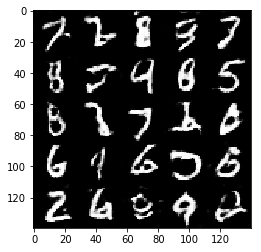

Epoch 2/2... Batch Count 2500... Discriminator Loss: 0.8956... Generator Loss: 1.7456
Epoch 2/2... Batch Count 2510... Discriminator Loss: 1.2012... Generator Loss: 0.6820
Epoch 2/2... Batch Count 2520... Discriminator Loss: 0.7156... Generator Loss: 2.0254
Epoch 2/2... Batch Count 2530... Discriminator Loss: 1.2929... Generator Loss: 0.7803
Epoch 2/2... Batch Count 2540... Discriminator Loss: 0.8538... Generator Loss: 1.1495
Epoch 2/2... Batch Count 2550... Discriminator Loss: 0.7209... Generator Loss: 1.3213
Epoch 2/2... Batch Count 2560... Discriminator Loss: 1.4662... Generator Loss: 0.5370
Epoch 2/2... Batch Count 2570... Discriminator Loss: 0.9810... Generator Loss: 1.0535
Epoch 2/2... Batch Count 2580... Discriminator Loss: 0.6480... Generator Loss: 1.8306
Epoch 2/2... Batch Count 2590... Discriminator Loss: 0.8024... Generator Loss: 1.4027


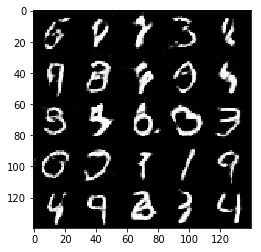

Epoch 2/2... Batch Count 2600... Discriminator Loss: 0.6218... Generator Loss: 2.2610
Epoch 2/2... Batch Count 2610... Discriminator Loss: 1.3163... Generator Loss: 0.7058
Epoch 2/2... Batch Count 2620... Discriminator Loss: 0.6035... Generator Loss: 1.8531
Epoch 2/2... Batch Count 2630... Discriminator Loss: 0.5875... Generator Loss: 3.4702
Epoch 2/2... Batch Count 2640... Discriminator Loss: 0.7857... Generator Loss: 1.6625
Epoch 2/2... Batch Count 2650... Discriminator Loss: 1.0175... Generator Loss: 0.9306
Epoch 2/2... Batch Count 2660... Discriminator Loss: 0.7351... Generator Loss: 1.4077
Epoch 2/2... Batch Count 2670... Discriminator Loss: 0.9178... Generator Loss: 0.9290
Epoch 2/2... Batch Count 2680... Discriminator Loss: 0.6265... Generator Loss: 1.6458
Epoch 2/2... Batch Count 2690... Discriminator Loss: 0.4827... Generator Loss: 2.4115


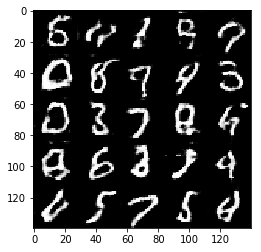

Epoch 2/2... Batch Count 2700... Discriminator Loss: 0.8741... Generator Loss: 1.0921
Epoch 2/2... Batch Count 2710... Discriminator Loss: 0.7613... Generator Loss: 1.2657
Epoch 2/2... Batch Count 2720... Discriminator Loss: 0.8406... Generator Loss: 1.0958
Epoch 2/2... Batch Count 2730... Discriminator Loss: 1.3636... Generator Loss: 0.5636
Epoch 2/2... Batch Count 2740... Discriminator Loss: 0.7189... Generator Loss: 1.9756
Epoch 2/2... Batch Count 2750... Discriminator Loss: 1.2150... Generator Loss: 0.7117
Epoch 2/2... Batch Count 2760... Discriminator Loss: 0.6453... Generator Loss: 1.9373
Epoch 2/2... Batch Count 2770... Discriminator Loss: 0.6958... Generator Loss: 1.6894
Epoch 2/2... Batch Count 2780... Discriminator Loss: 0.7407... Generator Loss: 1.4432
Epoch 2/2... Batch Count 2790... Discriminator Loss: 0.8687... Generator Loss: 1.1823


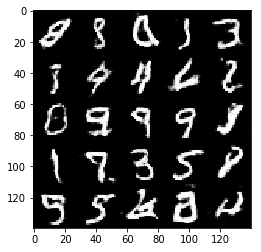

Epoch 2/2... Batch Count 2800... Discriminator Loss: 0.7659... Generator Loss: 1.3300
Epoch 2/2... Batch Count 2810... Discriminator Loss: 0.8476... Generator Loss: 1.2794
Epoch 2/2... Batch Count 2820... Discriminator Loss: 0.9069... Generator Loss: 1.0877
Epoch 2/2... Batch Count 2830... Discriminator Loss: 0.5590... Generator Loss: 2.1355
Epoch 2/2... Batch Count 2840... Discriminator Loss: 0.9960... Generator Loss: 0.9514
Epoch 2/2... Batch Count 2850... Discriminator Loss: 0.7714... Generator Loss: 1.2193
Epoch 2/2... Batch Count 2860... Discriminator Loss: 0.9145... Generator Loss: 1.0340
Epoch 2/2... Batch Count 2870... Discriminator Loss: 0.9910... Generator Loss: 0.9585
Epoch 2/2... Batch Count 2880... Discriminator Loss: 0.6773... Generator Loss: 1.5200
Epoch 2/2... Batch Count 2890... Discriminator Loss: 0.4720... Generator Loss: 2.5416


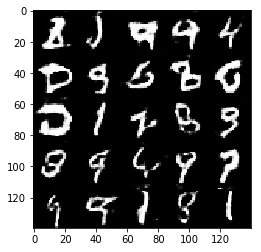

Epoch 2/2... Batch Count 2900... Discriminator Loss: 0.9193... Generator Loss: 2.9973
Epoch 2/2... Batch Count 2910... Discriminator Loss: 0.8086... Generator Loss: 1.2199
Epoch 2/2... Batch Count 2920... Discriminator Loss: 0.9122... Generator Loss: 1.1882
Epoch 2/2... Batch Count 2930... Discriminator Loss: 0.7183... Generator Loss: 2.3698
Epoch 2/2... Batch Count 2940... Discriminator Loss: 0.7538... Generator Loss: 1.3211
Epoch 2/2... Batch Count 2950... Discriminator Loss: 0.6087... Generator Loss: 1.7257
Epoch 2/2... Batch Count 2960... Discriminator Loss: 0.7656... Generator Loss: 1.1754
Epoch 2/2... Batch Count 2970... Discriminator Loss: 0.8756... Generator Loss: 1.0123
Epoch 2/2... Batch Count 2980... Discriminator Loss: 0.5819... Generator Loss: 1.9182
Epoch 2/2... Batch Count 2990... Discriminator Loss: 0.7175... Generator Loss: 1.4381


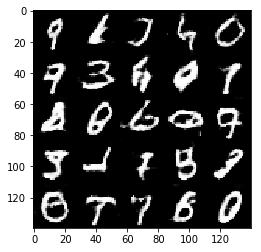

Epoch 2/2... Batch Count 3000... Discriminator Loss: 0.7626... Generator Loss: 1.3683
Epoch 2/2... Batch Count 3010... Discriminator Loss: 0.7746... Generator Loss: 1.5753
Epoch 2/2... Batch Count 3020... Discriminator Loss: 0.9445... Generator Loss: 1.0499
Epoch 2/2... Batch Count 3030... Discriminator Loss: 0.7089... Generator Loss: 2.5448
Epoch 2/2... Batch Count 3040... Discriminator Loss: 0.6006... Generator Loss: 1.7825
Epoch 2/2... Batch Count 3050... Discriminator Loss: 0.8573... Generator Loss: 1.1603
Epoch 2/2... Batch Count 3060... Discriminator Loss: 0.5685... Generator Loss: 2.1499
Epoch 2/2... Batch Count 3070... Discriminator Loss: 0.4437... Generator Loss: 2.5801
Epoch 2/2... Batch Count 3080... Discriminator Loss: 0.6714... Generator Loss: 1.6221
Epoch 2/2... Batch Count 3090... Discriminator Loss: 1.3863... Generator Loss: 0.5724


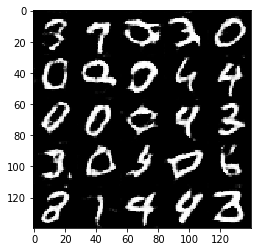

Epoch 2/2... Batch Count 3100... Discriminator Loss: 0.8527... Generator Loss: 1.3577
Epoch 2/2... Batch Count 3110... Discriminator Loss: 0.7467... Generator Loss: 1.2830
Epoch 2/2... Batch Count 3120... Discriminator Loss: 0.8011... Generator Loss: 1.2271
Epoch 2/2... Batch Count 3130... Discriminator Loss: 1.6938... Generator Loss: 0.4513
Epoch 2/2... Batch Count 3140... Discriminator Loss: 0.6738... Generator Loss: 1.5518
Epoch 2/2... Batch Count 3150... Discriminator Loss: 1.1082... Generator Loss: 0.8330
Epoch 2/2... Batch Count 3160... Discriminator Loss: 0.6752... Generator Loss: 2.2115
Epoch 2/2... Batch Count 3170... Discriminator Loss: 0.9307... Generator Loss: 0.9536
Epoch 2/2... Batch Count 3180... Discriminator Loss: 0.9096... Generator Loss: 1.0106
Epoch 2/2... Batch Count 3190... Discriminator Loss: 0.9572... Generator Loss: 0.9560


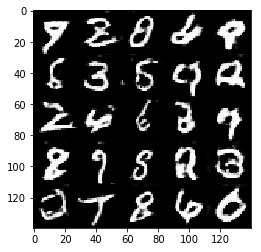

Epoch 2/2... Batch Count 3200... Discriminator Loss: 0.6007... Generator Loss: 1.8774
Epoch 2/2... Batch Count 3210... Discriminator Loss: 0.8509... Generator Loss: 1.1905
Epoch 2/2... Batch Count 3220... Discriminator Loss: 0.7448... Generator Loss: 1.3123
Epoch 2/2... Batch Count 3230... Discriminator Loss: 1.1893... Generator Loss: 0.7319
Epoch 2/2... Batch Count 3240... Discriminator Loss: 0.5371... Generator Loss: 2.4959
Epoch 2/2... Batch Count 3250... Discriminator Loss: 1.2049... Generator Loss: 1.0062
Epoch 2/2... Batch Count 3260... Discriminator Loss: 1.7793... Generator Loss: 0.4235
Epoch 2/2... Batch Count 3270... Discriminator Loss: 0.6253... Generator Loss: 1.7520
Epoch 2/2... Batch Count 3280... Discriminator Loss: 1.0098... Generator Loss: 1.0095
Epoch 2/2... Batch Count 3290... Discriminator Loss: 0.8131... Generator Loss: 1.1798


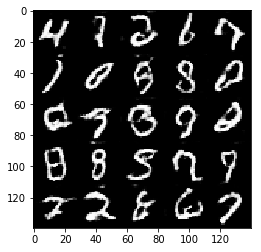

Epoch 2/2... Batch Count 3300... Discriminator Loss: 0.6196... Generator Loss: 1.7454
Epoch 2/2... Batch Count 3310... Discriminator Loss: 0.5403... Generator Loss: 1.9239
Epoch 2/2... Batch Count 3320... Discriminator Loss: 0.6436... Generator Loss: 1.6817
Epoch 2/2... Batch Count 3330... Discriminator Loss: 0.9224... Generator Loss: 1.0001
Epoch 2/2... Batch Count 3340... Discriminator Loss: 1.0607... Generator Loss: 0.9236
Epoch 2/2... Batch Count 3350... Discriminator Loss: 1.0319... Generator Loss: 0.8987
Epoch 2/2... Batch Count 3360... Discriminator Loss: 0.5096... Generator Loss: 2.7808
Epoch 2/2... Batch Count 3370... Discriminator Loss: 0.7110... Generator Loss: 1.5433
Epoch 2/2... Batch Count 3380... Discriminator Loss: 0.6540... Generator Loss: 1.5434
Epoch 2/2... Batch Count 3390... Discriminator Loss: 0.6603... Generator Loss: 1.6576


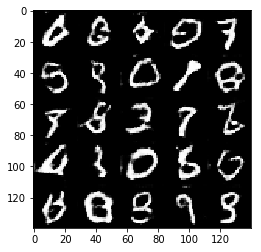

Epoch 2/2... Batch Count 3400... Discriminator Loss: 1.3637... Generator Loss: 0.5794
Epoch 2/2... Batch Count 3410... Discriminator Loss: 0.8800... Generator Loss: 1.2445
Epoch 2/2... Batch Count 3420... Discriminator Loss: 1.0893... Generator Loss: 0.8867
Epoch 2/2... Batch Count 3430... Discriminator Loss: 0.8353... Generator Loss: 1.1709
Epoch 2/2... Batch Count 3440... Discriminator Loss: 0.7349... Generator Loss: 1.3483
Epoch 2/2... Batch Count 3450... Discriminator Loss: 0.9455... Generator Loss: 0.9509
Epoch 2/2... Batch Count 3460... Discriminator Loss: 0.6450... Generator Loss: 1.6662
Epoch 2/2... Batch Count 3470... Discriminator Loss: 0.6537... Generator Loss: 1.6591
Epoch 2/2... Batch Count 3480... Discriminator Loss: 0.5740... Generator Loss: 2.3092
Epoch 2/2... Batch Count 3490... Discriminator Loss: 0.8530... Generator Loss: 1.1863


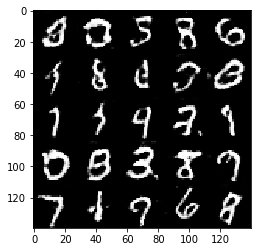

Epoch 2/2... Batch Count 3500... Discriminator Loss: 0.6273... Generator Loss: 1.8812
Epoch 2/2... Batch Count 3510... Discriminator Loss: 0.8778... Generator Loss: 1.0985
Epoch 2/2... Batch Count 3520... Discriminator Loss: 0.8352... Generator Loss: 1.2821
Epoch 2/2... Batch Count 3530... Discriminator Loss: 0.6160... Generator Loss: 1.7505
Epoch 2/2... Batch Count 3540... Discriminator Loss: 0.5059... Generator Loss: 2.3848
Epoch 2/2... Batch Count 3550... Discriminator Loss: 0.8157... Generator Loss: 1.1933
Epoch 2/2... Batch Count 3560... Discriminator Loss: 0.6514... Generator Loss: 1.6470
Epoch 2/2... Batch Count 3570... Discriminator Loss: 0.8591... Generator Loss: 1.4669
Epoch 2/2... Batch Count 3580... Discriminator Loss: 0.9992... Generator Loss: 1.0616
Epoch 2/2... Batch Count 3590... Discriminator Loss: 2.0051... Generator Loss: 0.5236


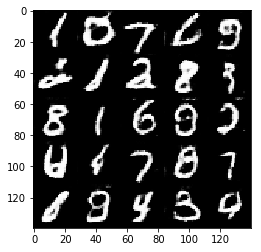

Epoch 2/2... Batch Count 3600... Discriminator Loss: 0.5203... Generator Loss: 3.0741
Epoch 2/2... Batch Count 3610... Discriminator Loss: 0.6428... Generator Loss: 2.0863
Epoch 2/2... Batch Count 3620... Discriminator Loss: 1.0421... Generator Loss: 0.8452
Epoch 2/2... Batch Count 3630... Discriminator Loss: 0.6692... Generator Loss: 1.6099
Epoch 2/2... Batch Count 3640... Discriminator Loss: 0.7314... Generator Loss: 1.3823
Epoch 2/2... Batch Count 3650... Discriminator Loss: 0.5082... Generator Loss: 2.5843
Epoch 2/2... Batch Count 3660... Discriminator Loss: 0.9439... Generator Loss: 1.0594
Epoch 2/2... Batch Count 3670... Discriminator Loss: 0.6564... Generator Loss: 1.7576
Epoch 2/2... Batch Count 3680... Discriminator Loss: 0.7624... Generator Loss: 1.2416
Epoch 2/2... Batch Count 3690... Discriminator Loss: 0.8397... Generator Loss: 1.2173


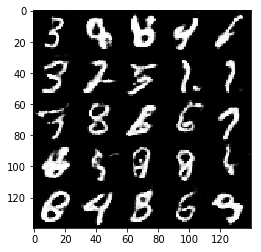

Epoch 2/2... Batch Count 3700... Discriminator Loss: 0.7065... Generator Loss: 1.6706
Epoch 2/2... Batch Count 3710... Discriminator Loss: 0.8090... Generator Loss: 1.3480
Epoch 2/2... Batch Count 3720... Discriminator Loss: 0.5754... Generator Loss: 1.8364
Epoch 2/2... Batch Count 3730... Discriminator Loss: 0.8486... Generator Loss: 1.1144
Epoch 2/2... Batch Count 3740... Discriminator Loss: 0.9972... Generator Loss: 0.9519
Epoch 2/2... Batch Count 3750... Discriminator Loss: 0.5909... Generator Loss: 1.8075


In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.6
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch Count 10... Discriminator Loss: 0.6464... Generator Loss: 2.5389
Epoch 1/1... Batch Count 20... Discriminator Loss: 0.8802... Generator Loss: 1.5653
Epoch 1/1... Batch Count 30... Discriminator Loss: 0.5277... Generator Loss: 3.5767
Epoch 1/1... Batch Count 40... Discriminator Loss: 0.7039... Generator Loss: 3.8000
Epoch 1/1... Batch Count 50... Discriminator Loss: 0.7935... Generator Loss: 2.2034
Epoch 1/1... Batch Count 60... Discriminator Loss: 1.5185... Generator Loss: 2.7120
Epoch 1/1... Batch Count 70... Discriminator Loss: 0.8613... Generator Loss: 1.5964
Epoch 1/1... Batch Count 80... Discriminator Loss: 0.8693... Generator Loss: 1.1204
Epoch 1/1... Batch Count 90... Discriminator Loss: 0.6691... Generator Loss: 1.8170


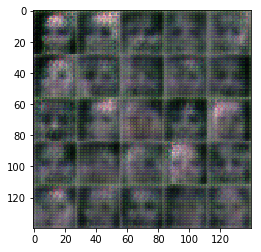

Epoch 1/1... Batch Count 100... Discriminator Loss: 0.9231... Generator Loss: 4.8977
Epoch 1/1... Batch Count 110... Discriminator Loss: 0.6380... Generator Loss: 2.4380
Epoch 1/1... Batch Count 120... Discriminator Loss: 0.5680... Generator Loss: 2.1501
Epoch 1/1... Batch Count 130... Discriminator Loss: 0.4583... Generator Loss: 3.2549
Epoch 1/1... Batch Count 140... Discriminator Loss: 0.9275... Generator Loss: 0.9547
Epoch 1/1... Batch Count 150... Discriminator Loss: 0.8796... Generator Loss: 2.5807
Epoch 1/1... Batch Count 160... Discriminator Loss: 0.5385... Generator Loss: 2.2925
Epoch 1/1... Batch Count 170... Discriminator Loss: 0.9379... Generator Loss: 0.9298
Epoch 1/1... Batch Count 180... Discriminator Loss: 0.6707... Generator Loss: 1.8745
Epoch 1/1... Batch Count 190... Discriminator Loss: 0.6238... Generator Loss: 1.7787


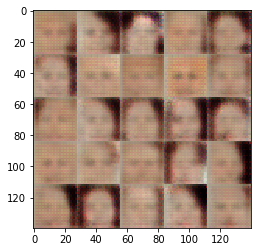

Epoch 1/1... Batch Count 200... Discriminator Loss: 1.2531... Generator Loss: 0.7570
Epoch 1/1... Batch Count 210... Discriminator Loss: 2.1734... Generator Loss: 0.2249
Epoch 1/1... Batch Count 220... Discriminator Loss: 1.0970... Generator Loss: 1.0270
Epoch 1/1... Batch Count 230... Discriminator Loss: 1.0526... Generator Loss: 1.1392
Epoch 1/1... Batch Count 240... Discriminator Loss: 1.5637... Generator Loss: 0.4341
Epoch 1/1... Batch Count 250... Discriminator Loss: 0.9425... Generator Loss: 1.0335
Epoch 1/1... Batch Count 260... Discriminator Loss: 0.9662... Generator Loss: 1.4745
Epoch 1/1... Batch Count 270... Discriminator Loss: 0.9246... Generator Loss: 1.2429
Epoch 1/1... Batch Count 280... Discriminator Loss: 1.2278... Generator Loss: 0.9719
Epoch 1/1... Batch Count 290... Discriminator Loss: 3.1163... Generator Loss: 4.0248


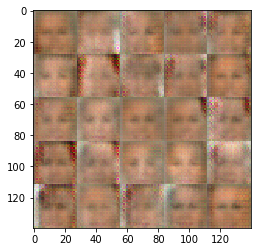

Epoch 1/1... Batch Count 300... Discriminator Loss: 1.1359... Generator Loss: 1.2732
Epoch 1/1... Batch Count 310... Discriminator Loss: 1.2256... Generator Loss: 0.7018
Epoch 1/1... Batch Count 320... Discriminator Loss: 1.5941... Generator Loss: 0.3613
Epoch 1/1... Batch Count 330... Discriminator Loss: 1.1805... Generator Loss: 0.7271
Epoch 1/1... Batch Count 340... Discriminator Loss: 1.1502... Generator Loss: 0.8896
Epoch 1/1... Batch Count 350... Discriminator Loss: 1.1854... Generator Loss: 0.7411
Epoch 1/1... Batch Count 360... Discriminator Loss: 1.5754... Generator Loss: 0.6007
Epoch 1/1... Batch Count 370... Discriminator Loss: 0.8200... Generator Loss: 1.9881
Epoch 1/1... Batch Count 380... Discriminator Loss: 1.6935... Generator Loss: 2.1792
Epoch 1/1... Batch Count 390... Discriminator Loss: 1.0594... Generator Loss: 1.3301


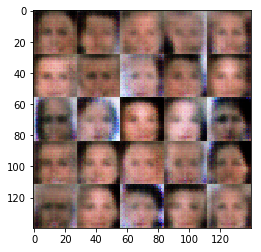

Epoch 1/1... Batch Count 400... Discriminator Loss: 1.3142... Generator Loss: 0.9310
Epoch 1/1... Batch Count 410... Discriminator Loss: 1.3838... Generator Loss: 0.8759
Epoch 1/1... Batch Count 420... Discriminator Loss: 1.0393... Generator Loss: 1.0044
Epoch 1/1... Batch Count 430... Discriminator Loss: 1.3826... Generator Loss: 0.7440
Epoch 1/1... Batch Count 440... Discriminator Loss: 1.3455... Generator Loss: 0.8029
Epoch 1/1... Batch Count 450... Discriminator Loss: 1.4221... Generator Loss: 0.8920
Epoch 1/1... Batch Count 460... Discriminator Loss: 1.4227... Generator Loss: 0.6789
Epoch 1/1... Batch Count 470... Discriminator Loss: 1.3817... Generator Loss: 0.9359
Epoch 1/1... Batch Count 480... Discriminator Loss: 1.3457... Generator Loss: 0.8525
Epoch 1/1... Batch Count 490... Discriminator Loss: 1.4580... Generator Loss: 0.7391


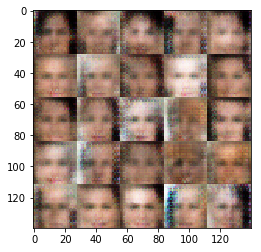

Epoch 1/1... Batch Count 500... Discriminator Loss: 1.3599... Generator Loss: 0.7878
Epoch 1/1... Batch Count 510... Discriminator Loss: 1.4550... Generator Loss: 0.8458
Epoch 1/1... Batch Count 520... Discriminator Loss: 1.2266... Generator Loss: 0.9380
Epoch 1/1... Batch Count 530... Discriminator Loss: 1.5301... Generator Loss: 0.9053
Epoch 1/1... Batch Count 540... Discriminator Loss: 1.2472... Generator Loss: 0.8873
Epoch 1/1... Batch Count 550... Discriminator Loss: 1.2866... Generator Loss: 1.0779
Epoch 1/1... Batch Count 560... Discriminator Loss: 1.2453... Generator Loss: 1.0053
Epoch 1/1... Batch Count 570... Discriminator Loss: 1.1085... Generator Loss: 1.3386
Epoch 1/1... Batch Count 580... Discriminator Loss: 1.3786... Generator Loss: 0.6201
Epoch 1/1... Batch Count 590... Discriminator Loss: 1.4209... Generator Loss: 0.9810


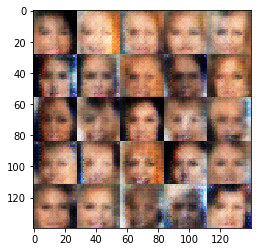

Epoch 1/1... Batch Count 600... Discriminator Loss: 1.2679... Generator Loss: 0.7911
Epoch 1/1... Batch Count 610... Discriminator Loss: 1.1907... Generator Loss: 0.9729
Epoch 1/1... Batch Count 620... Discriminator Loss: 1.2032... Generator Loss: 0.8341
Epoch 1/1... Batch Count 630... Discriminator Loss: 1.1883... Generator Loss: 1.7862
Epoch 1/1... Batch Count 640... Discriminator Loss: 1.3610... Generator Loss: 0.7412
Epoch 1/1... Batch Count 650... Discriminator Loss: 1.3434... Generator Loss: 0.6249
Epoch 1/1... Batch Count 660... Discriminator Loss: 1.1895... Generator Loss: 1.0507
Epoch 1/1... Batch Count 670... Discriminator Loss: 0.6749... Generator Loss: 1.4459
Epoch 1/1... Batch Count 680... Discriminator Loss: 1.2583... Generator Loss: 0.6042
Epoch 1/1... Batch Count 690... Discriminator Loss: 0.9464... Generator Loss: 2.5421


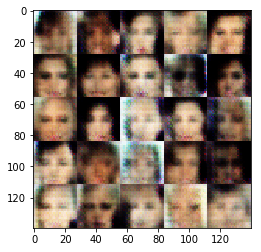

Epoch 1/1... Batch Count 700... Discriminator Loss: 1.1117... Generator Loss: 0.8271
Epoch 1/1... Batch Count 710... Discriminator Loss: 0.8909... Generator Loss: 0.9326
Epoch 1/1... Batch Count 720... Discriminator Loss: 1.6805... Generator Loss: 0.3757
Epoch 1/1... Batch Count 730... Discriminator Loss: 0.5940... Generator Loss: 2.7121
Epoch 1/1... Batch Count 740... Discriminator Loss: 0.6664... Generator Loss: 1.5207
Epoch 1/1... Batch Count 750... Discriminator Loss: 0.8647... Generator Loss: 2.3860
Epoch 1/1... Batch Count 760... Discriminator Loss: 1.6327... Generator Loss: 4.0214
Epoch 1/1... Batch Count 770... Discriminator Loss: 1.2825... Generator Loss: 0.6664
Epoch 1/1... Batch Count 780... Discriminator Loss: 0.5159... Generator Loss: 2.3952
Epoch 1/1... Batch Count 790... Discriminator Loss: 0.7345... Generator Loss: 2.0656


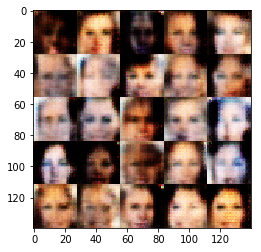

Epoch 1/1... Batch Count 800... Discriminator Loss: 1.0557... Generator Loss: 1.7821
Epoch 1/1... Batch Count 810... Discriminator Loss: 0.9380... Generator Loss: 0.8408
Epoch 1/1... Batch Count 820... Discriminator Loss: 0.4104... Generator Loss: 2.8704
Epoch 1/1... Batch Count 830... Discriminator Loss: 0.9423... Generator Loss: 3.8987
Epoch 1/1... Batch Count 840... Discriminator Loss: 0.4332... Generator Loss: 3.4345
Epoch 1/1... Batch Count 850... Discriminator Loss: 1.3444... Generator Loss: 0.5044
Epoch 1/1... Batch Count 860... Discriminator Loss: 1.1305... Generator Loss: 0.6903
Epoch 1/1... Batch Count 870... Discriminator Loss: 0.8010... Generator Loss: 2.5051
Epoch 1/1... Batch Count 880... Discriminator Loss: 0.4565... Generator Loss: 2.6390
Epoch 1/1... Batch Count 890... Discriminator Loss: 0.8201... Generator Loss: 1.3303


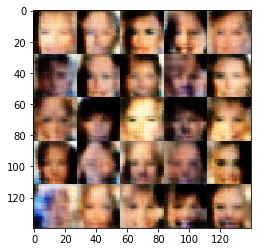

Epoch 1/1... Batch Count 900... Discriminator Loss: 3.3119... Generator Loss: 0.0704
Epoch 1/1... Batch Count 910... Discriminator Loss: 0.9452... Generator Loss: 2.1519
Epoch 1/1... Batch Count 920... Discriminator Loss: 0.4091... Generator Loss: 3.2849
Epoch 1/1... Batch Count 930... Discriminator Loss: 0.7620... Generator Loss: 1.2120
Epoch 1/1... Batch Count 940... Discriminator Loss: 1.0404... Generator Loss: 0.8568
Epoch 1/1... Batch Count 950... Discriminator Loss: 0.5957... Generator Loss: 1.5689
Epoch 1/1... Batch Count 960... Discriminator Loss: 0.9955... Generator Loss: 0.9593
Epoch 1/1... Batch Count 970... Discriminator Loss: 0.4098... Generator Loss: 3.3872
Epoch 1/1... Batch Count 980... Discriminator Loss: 0.6167... Generator Loss: 3.8417
Epoch 1/1... Batch Count 990... Discriminator Loss: 1.0529... Generator Loss: 0.7533


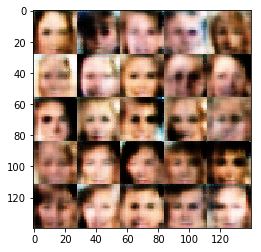

Epoch 1/1... Batch Count 1000... Discriminator Loss: 0.7506... Generator Loss: 2.4615
Epoch 1/1... Batch Count 1010... Discriminator Loss: 0.5935... Generator Loss: 1.7655
Epoch 1/1... Batch Count 1020... Discriminator Loss: 0.9455... Generator Loss: 0.9415
Epoch 1/1... Batch Count 1030... Discriminator Loss: 0.4720... Generator Loss: 2.8327
Epoch 1/1... Batch Count 1040... Discriminator Loss: 0.3634... Generator Loss: 4.3999
Epoch 1/1... Batch Count 1050... Discriminator Loss: 0.4918... Generator Loss: 2.6037
Epoch 1/1... Batch Count 1060... Discriminator Loss: 0.7205... Generator Loss: 1.4431
Epoch 1/1... Batch Count 1070... Discriminator Loss: 1.0346... Generator Loss: 1.1440
Epoch 1/1... Batch Count 1080... Discriminator Loss: 0.7397... Generator Loss: 1.2347
Epoch 1/1... Batch Count 1090... Discriminator Loss: 0.9112... Generator Loss: 2.8354


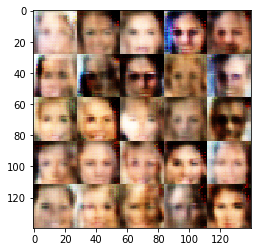

Epoch 1/1... Batch Count 1100... Discriminator Loss: 1.0502... Generator Loss: 0.8092
Epoch 1/1... Batch Count 1110... Discriminator Loss: 0.8812... Generator Loss: 1.4540
Epoch 1/1... Batch Count 1120... Discriminator Loss: 0.3780... Generator Loss: 4.6595
Epoch 1/1... Batch Count 1130... Discriminator Loss: 0.5108... Generator Loss: 2.8400
Epoch 1/1... Batch Count 1140... Discriminator Loss: 0.7074... Generator Loss: 1.6628
Epoch 1/1... Batch Count 1150... Discriminator Loss: 0.5425... Generator Loss: 1.8787
Epoch 1/1... Batch Count 1160... Discriminator Loss: 1.9348... Generator Loss: 0.2967
Epoch 1/1... Batch Count 1170... Discriminator Loss: 1.0535... Generator Loss: 0.9017
Epoch 1/1... Batch Count 1180... Discriminator Loss: 1.0594... Generator Loss: 0.8206
Epoch 1/1... Batch Count 1190... Discriminator Loss: 0.8101... Generator Loss: 1.4058


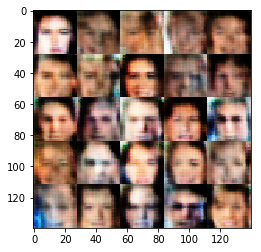

Epoch 1/1... Batch Count 1200... Discriminator Loss: 0.6857... Generator Loss: 1.6374
Epoch 1/1... Batch Count 1210... Discriminator Loss: 1.3423... Generator Loss: 0.5294
Epoch 1/1... Batch Count 1220... Discriminator Loss: 0.6301... Generator Loss: 1.8573
Epoch 1/1... Batch Count 1230... Discriminator Loss: 0.5306... Generator Loss: 1.9312
Epoch 1/1... Batch Count 1240... Discriminator Loss: 0.3823... Generator Loss: 3.8682
Epoch 1/1... Batch Count 1250... Discriminator Loss: 0.4062... Generator Loss: 3.3692
Epoch 1/1... Batch Count 1260... Discriminator Loss: 0.8757... Generator Loss: 0.9688
Epoch 1/1... Batch Count 1270... Discriminator Loss: 0.4679... Generator Loss: 2.3887
Epoch 1/1... Batch Count 1280... Discriminator Loss: 1.9249... Generator Loss: 4.8089
Epoch 1/1... Batch Count 1290... Discriminator Loss: 0.6986... Generator Loss: 1.4674


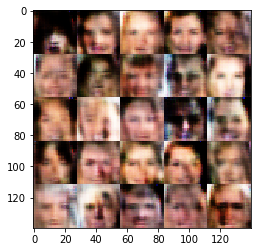

Epoch 1/1... Batch Count 1300... Discriminator Loss: 1.2670... Generator Loss: 0.5661
Epoch 1/1... Batch Count 1310... Discriminator Loss: 0.5571... Generator Loss: 3.2491
Epoch 1/1... Batch Count 1320... Discriminator Loss: 0.4860... Generator Loss: 2.4320
Epoch 1/1... Batch Count 1330... Discriminator Loss: 0.7391... Generator Loss: 1.3018
Epoch 1/1... Batch Count 1340... Discriminator Loss: 0.4616... Generator Loss: 2.7103
Epoch 1/1... Batch Count 1350... Discriminator Loss: 0.8543... Generator Loss: 2.4183
Epoch 1/1... Batch Count 1360... Discriminator Loss: 0.6658... Generator Loss: 1.4351
Epoch 1/1... Batch Count 1370... Discriminator Loss: 0.5685... Generator Loss: 1.9394
Epoch 1/1... Batch Count 1380... Discriminator Loss: 0.9135... Generator Loss: 0.9945
Epoch 1/1... Batch Count 1390... Discriminator Loss: 1.0733... Generator Loss: 0.7687


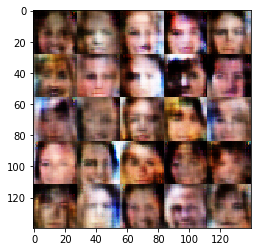

Epoch 1/1... Batch Count 1400... Discriminator Loss: 0.4055... Generator Loss: 3.3233
Epoch 1/1... Batch Count 1410... Discriminator Loss: 0.3768... Generator Loss: 4.0370
Epoch 1/1... Batch Count 1420... Discriminator Loss: 0.4202... Generator Loss: 3.6246
Epoch 1/1... Batch Count 1430... Discriminator Loss: 1.1591... Generator Loss: 3.6012
Epoch 1/1... Batch Count 1440... Discriminator Loss: 1.2194... Generator Loss: 0.7512
Epoch 1/1... Batch Count 1450... Discriminator Loss: 0.8927... Generator Loss: 3.2686
Epoch 1/1... Batch Count 1460... Discriminator Loss: 0.4503... Generator Loss: 4.0144
Epoch 1/1... Batch Count 1470... Discriminator Loss: 0.3909... Generator Loss: 3.9536
Epoch 1/1... Batch Count 1480... Discriminator Loss: 1.0875... Generator Loss: 0.8287
Epoch 1/1... Batch Count 1490... Discriminator Loss: 1.2251... Generator Loss: 0.6810


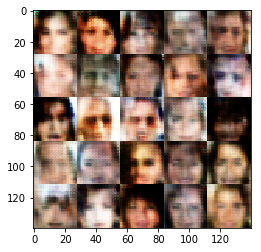

Epoch 1/1... Batch Count 1500... Discriminator Loss: 0.4080... Generator Loss: 3.5258
Epoch 1/1... Batch Count 1510... Discriminator Loss: 0.4520... Generator Loss: 2.8321
Epoch 1/1... Batch Count 1520... Discriminator Loss: 0.6899... Generator Loss: 2.3171
Epoch 1/1... Batch Count 1530... Discriminator Loss: 0.6385... Generator Loss: 1.7486
Epoch 1/1... Batch Count 1540... Discriminator Loss: 1.0131... Generator Loss: 2.9423
Epoch 1/1... Batch Count 1550... Discriminator Loss: 0.5272... Generator Loss: 2.4114
Epoch 1/1... Batch Count 1560... Discriminator Loss: 0.8890... Generator Loss: 1.1769
Epoch 1/1... Batch Count 1570... Discriminator Loss: 0.8022... Generator Loss: 1.1580
Epoch 1/1... Batch Count 1580... Discriminator Loss: 0.4583... Generator Loss: 2.4157
Epoch 1/1... Batch Count 1590... Discriminator Loss: 1.2118... Generator Loss: 0.7887


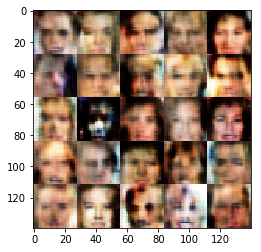

Epoch 1/1... Batch Count 1600... Discriminator Loss: 1.3447... Generator Loss: 0.5213
Epoch 1/1... Batch Count 1610... Discriminator Loss: 0.8988... Generator Loss: 3.1121
Epoch 1/1... Batch Count 1620... Discriminator Loss: 1.5654... Generator Loss: 3.4165
Epoch 1/1... Batch Count 1630... Discriminator Loss: 1.0584... Generator Loss: 0.7619
Epoch 1/1... Batch Count 1640... Discriminator Loss: 0.5897... Generator Loss: 1.7998
Epoch 1/1... Batch Count 1650... Discriminator Loss: 0.3912... Generator Loss: 3.2651
Epoch 1/1... Batch Count 1660... Discriminator Loss: 0.3782... Generator Loss: 4.5465
Epoch 1/1... Batch Count 1670... Discriminator Loss: 0.3982... Generator Loss: 3.1538
Epoch 1/1... Batch Count 1680... Discriminator Loss: 0.4676... Generator Loss: 3.7657
Epoch 1/1... Batch Count 1690... Discriminator Loss: 0.5493... Generator Loss: 1.8888


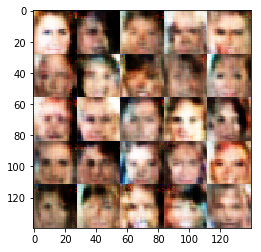

Epoch 1/1... Batch Count 1700... Discriminator Loss: 1.0381... Generator Loss: 2.3157
Epoch 1/1... Batch Count 1710... Discriminator Loss: 0.8571... Generator Loss: 2.7502
Epoch 1/1... Batch Count 1720... Discriminator Loss: 0.5509... Generator Loss: 3.9705
Epoch 1/1... Batch Count 1730... Discriminator Loss: 0.4613... Generator Loss: 4.2655
Epoch 1/1... Batch Count 1740... Discriminator Loss: 0.5772... Generator Loss: 1.7048
Epoch 1/1... Batch Count 1750... Discriminator Loss: 0.6666... Generator Loss: 1.6885
Epoch 1/1... Batch Count 1760... Discriminator Loss: 0.5285... Generator Loss: 1.9037
Epoch 1/1... Batch Count 1770... Discriminator Loss: 0.3893... Generator Loss: 4.0302
Epoch 1/1... Batch Count 1780... Discriminator Loss: 0.4006... Generator Loss: 3.1361
Epoch 1/1... Batch Count 1790... Discriminator Loss: 2.3755... Generator Loss: 2.5654


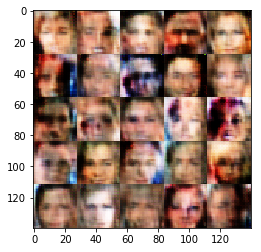

Epoch 1/1... Batch Count 1800... Discriminator Loss: 1.4951... Generator Loss: 0.4971
Epoch 1/1... Batch Count 1810... Discriminator Loss: 0.8564... Generator Loss: 0.9874
Epoch 1/1... Batch Count 1820... Discriminator Loss: 0.5846... Generator Loss: 2.8784
Epoch 1/1... Batch Count 1830... Discriminator Loss: 0.5360... Generator Loss: 2.1775
Epoch 1/1... Batch Count 1840... Discriminator Loss: 0.7975... Generator Loss: 1.2014
Epoch 1/1... Batch Count 1850... Discriminator Loss: 0.8910... Generator Loss: 1.0344
Epoch 1/1... Batch Count 1860... Discriminator Loss: 0.8300... Generator Loss: 2.8303
Epoch 1/1... Batch Count 1870... Discriminator Loss: 0.7445... Generator Loss: 2.2799
Epoch 1/1... Batch Count 1880... Discriminator Loss: 0.5479... Generator Loss: 2.6660
Epoch 1/1... Batch Count 1890... Discriminator Loss: 0.5405... Generator Loss: 3.1403


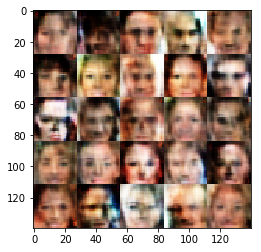

Epoch 1/1... Batch Count 1900... Discriminator Loss: 0.5597... Generator Loss: 2.7287
Epoch 1/1... Batch Count 1910... Discriminator Loss: 0.6260... Generator Loss: 1.5861
Epoch 1/1... Batch Count 1920... Discriminator Loss: 0.7522... Generator Loss: 1.3277
Epoch 1/1... Batch Count 1930... Discriminator Loss: 0.7923... Generator Loss: 1.1870
Epoch 1/1... Batch Count 1940... Discriminator Loss: 0.7346... Generator Loss: 3.1778
Epoch 1/1... Batch Count 1950... Discriminator Loss: 1.1687... Generator Loss: 1.0535
Epoch 1/1... Batch Count 1960... Discriminator Loss: 0.9450... Generator Loss: 1.2873
Epoch 1/1... Batch Count 1970... Discriminator Loss: 0.6810... Generator Loss: 1.7271
Epoch 1/1... Batch Count 1980... Discriminator Loss: 0.9418... Generator Loss: 0.9729
Epoch 1/1... Batch Count 1990... Discriminator Loss: 0.5698... Generator Loss: 2.3166


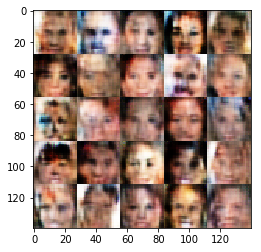

Epoch 1/1... Batch Count 2000... Discriminator Loss: 2.8231... Generator Loss: 2.6118
Epoch 1/1... Batch Count 2010... Discriminator Loss: 0.7145... Generator Loss: 1.3304
Epoch 1/1... Batch Count 2020... Discriminator Loss: 0.4508... Generator Loss: 2.5939
Epoch 1/1... Batch Count 2030... Discriminator Loss: 0.6830... Generator Loss: 1.3397
Epoch 1/1... Batch Count 2040... Discriminator Loss: 1.7373... Generator Loss: 0.3877
Epoch 1/1... Batch Count 2050... Discriminator Loss: 1.1905... Generator Loss: 1.5698
Epoch 1/1... Batch Count 2060... Discriminator Loss: 0.9992... Generator Loss: 0.9991
Epoch 1/1... Batch Count 2070... Discriminator Loss: 0.9956... Generator Loss: 0.8998
Epoch 1/1... Batch Count 2080... Discriminator Loss: 0.6602... Generator Loss: 1.5366
Epoch 1/1... Batch Count 2090... Discriminator Loss: 1.2787... Generator Loss: 0.6100


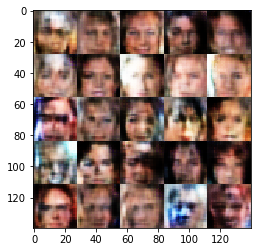

Epoch 1/1... Batch Count 2100... Discriminator Loss: 0.4731... Generator Loss: 2.9475
Epoch 1/1... Batch Count 2110... Discriminator Loss: 0.4180... Generator Loss: 3.0365
Epoch 1/1... Batch Count 2120... Discriminator Loss: 1.5603... Generator Loss: 0.6960
Epoch 1/1... Batch Count 2130... Discriminator Loss: 0.4595... Generator Loss: 4.4163
Epoch 1/1... Batch Count 2140... Discriminator Loss: 0.4214... Generator Loss: 2.7067
Epoch 1/1... Batch Count 2150... Discriminator Loss: 0.4754... Generator Loss: 2.5091
Epoch 1/1... Batch Count 2160... Discriminator Loss: 1.3095... Generator Loss: 0.6047
Epoch 1/1... Batch Count 2170... Discriminator Loss: 1.6774... Generator Loss: 0.3575
Epoch 1/1... Batch Count 2180... Discriminator Loss: 1.0810... Generator Loss: 1.4145
Epoch 1/1... Batch Count 2190... Discriminator Loss: 0.4731... Generator Loss: 3.0421


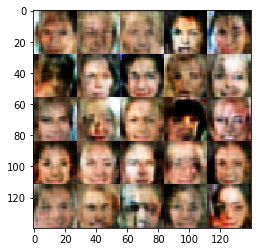

Epoch 1/1... Batch Count 2200... Discriminator Loss: 0.8470... Generator Loss: 1.1389
Epoch 1/1... Batch Count 2210... Discriminator Loss: 0.9254... Generator Loss: 1.9883
Epoch 1/1... Batch Count 2220... Discriminator Loss: 0.4552... Generator Loss: 2.5430
Epoch 1/1... Batch Count 2230... Discriminator Loss: 0.4314... Generator Loss: 2.7636
Epoch 1/1... Batch Count 2240... Discriminator Loss: 1.5097... Generator Loss: 0.5549
Epoch 1/1... Batch Count 2250... Discriminator Loss: 1.7897... Generator Loss: 0.3635
Epoch 1/1... Batch Count 2260... Discriminator Loss: 0.4645... Generator Loss: 3.1815
Epoch 1/1... Batch Count 2270... Discriminator Loss: 0.5524... Generator Loss: 1.9393
Epoch 1/1... Batch Count 2280... Discriminator Loss: 0.6318... Generator Loss: 1.6329
Epoch 1/1... Batch Count 2290... Discriminator Loss: 0.7735... Generator Loss: 2.6355


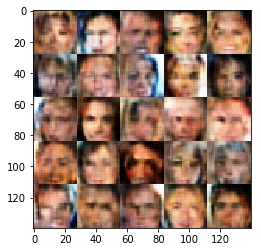

Epoch 1/1... Batch Count 2300... Discriminator Loss: 0.3607... Generator Loss: 4.3254
Epoch 1/1... Batch Count 2310... Discriminator Loss: 0.8007... Generator Loss: 1.3793
Epoch 1/1... Batch Count 2320... Discriminator Loss: 1.2032... Generator Loss: 0.6646
Epoch 1/1... Batch Count 2330... Discriminator Loss: 0.8733... Generator Loss: 1.0768
Epoch 1/1... Batch Count 2340... Discriminator Loss: 0.7141... Generator Loss: 1.8978
Epoch 1/1... Batch Count 2350... Discriminator Loss: 1.3723... Generator Loss: 0.5568
Epoch 1/1... Batch Count 2360... Discriminator Loss: 0.7524... Generator Loss: 1.3870
Epoch 1/1... Batch Count 2370... Discriminator Loss: 0.3901... Generator Loss: 3.5864
Epoch 1/1... Batch Count 2380... Discriminator Loss: 0.4451... Generator Loss: 2.6701
Epoch 1/1... Batch Count 2390... Discriminator Loss: 0.5708... Generator Loss: 2.4604


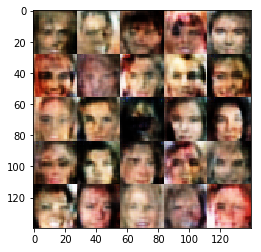

Epoch 1/1... Batch Count 2400... Discriminator Loss: 0.8176... Generator Loss: 1.5944
Epoch 1/1... Batch Count 2410... Discriminator Loss: 0.5497... Generator Loss: 2.2041
Epoch 1/1... Batch Count 2420... Discriminator Loss: 0.6712... Generator Loss: 1.9017
Epoch 1/1... Batch Count 2430... Discriminator Loss: 0.4803... Generator Loss: 2.3331
Epoch 1/1... Batch Count 2440... Discriminator Loss: 0.6234... Generator Loss: 1.8801
Epoch 1/1... Batch Count 2450... Discriminator Loss: 0.8562... Generator Loss: 1.8575
Epoch 1/1... Batch Count 2460... Discriminator Loss: 0.4388... Generator Loss: 3.0411
Epoch 1/1... Batch Count 2470... Discriminator Loss: 0.6700... Generator Loss: 1.4488
Epoch 1/1... Batch Count 2480... Discriminator Loss: 0.3596... Generator Loss: 5.5636
Epoch 1/1... Batch Count 2490... Discriminator Loss: 0.3886... Generator Loss: 3.8722


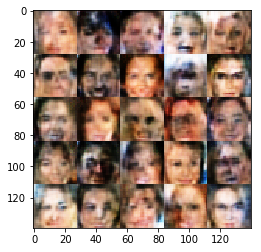

Epoch 1/1... Batch Count 2500... Discriminator Loss: 0.6441... Generator Loss: 2.6106
Epoch 1/1... Batch Count 2510... Discriminator Loss: 0.4952... Generator Loss: 2.2421
Epoch 1/1... Batch Count 2520... Discriminator Loss: 0.4168... Generator Loss: 2.9047
Epoch 1/1... Batch Count 2530... Discriminator Loss: 0.7827... Generator Loss: 1.2129
Epoch 1/1... Batch Count 2540... Discriminator Loss: 0.5510... Generator Loss: 1.8595
Epoch 1/1... Batch Count 2550... Discriminator Loss: 0.7015... Generator Loss: 1.5154
Epoch 1/1... Batch Count 2560... Discriminator Loss: 0.9534... Generator Loss: 2.5511
Epoch 1/1... Batch Count 2570... Discriminator Loss: 1.0920... Generator Loss: 1.1549
Epoch 1/1... Batch Count 2580... Discriminator Loss: 0.6988... Generator Loss: 1.6520
Epoch 1/1... Batch Count 2590... Discriminator Loss: 0.4961... Generator Loss: 2.4877


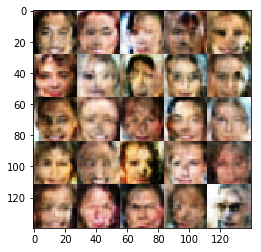

Epoch 1/1... Batch Count 2600... Discriminator Loss: 0.5273... Generator Loss: 3.8163
Epoch 1/1... Batch Count 2610... Discriminator Loss: 0.4980... Generator Loss: 2.1711
Epoch 1/1... Batch Count 2620... Discriminator Loss: 0.8866... Generator Loss: 1.0872
Epoch 1/1... Batch Count 2630... Discriminator Loss: 0.7068... Generator Loss: 1.6578
Epoch 1/1... Batch Count 2640... Discriminator Loss: 1.4108... Generator Loss: 2.5263
Epoch 1/1... Batch Count 2650... Discriminator Loss: 0.6903... Generator Loss: 2.7590
Epoch 1/1... Batch Count 2660... Discriminator Loss: 0.5282... Generator Loss: 3.8846
Epoch 1/1... Batch Count 2670... Discriminator Loss: 0.6506... Generator Loss: 2.5101
Epoch 1/1... Batch Count 2680... Discriminator Loss: 1.2852... Generator Loss: 0.6566
Epoch 1/1... Batch Count 2690... Discriminator Loss: 1.0059... Generator Loss: 2.2906


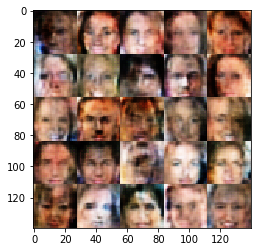

Epoch 1/1... Batch Count 2700... Discriminator Loss: 0.9131... Generator Loss: 2.5341
Epoch 1/1... Batch Count 2710... Discriminator Loss: 0.5648... Generator Loss: 1.9263
Epoch 1/1... Batch Count 2720... Discriminator Loss: 0.5294... Generator Loss: 2.1781
Epoch 1/1... Batch Count 2730... Discriminator Loss: 0.5881... Generator Loss: 2.5571
Epoch 1/1... Batch Count 2740... Discriminator Loss: 0.9554... Generator Loss: 4.5586
Epoch 1/1... Batch Count 2750... Discriminator Loss: 0.8147... Generator Loss: 1.3400
Epoch 1/1... Batch Count 2760... Discriminator Loss: 0.9956... Generator Loss: 1.0261
Epoch 1/1... Batch Count 2770... Discriminator Loss: 0.9342... Generator Loss: 1.0142
Epoch 1/1... Batch Count 2780... Discriminator Loss: 0.4821... Generator Loss: 2.5030
Epoch 1/1... Batch Count 2790... Discriminator Loss: 1.3178... Generator Loss: 0.5809


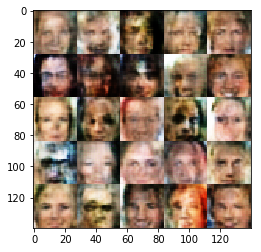

Epoch 1/1... Batch Count 2800... Discriminator Loss: 0.8362... Generator Loss: 1.1985
Epoch 1/1... Batch Count 2810... Discriminator Loss: 0.5062... Generator Loss: 2.1650
Epoch 1/1... Batch Count 2820... Discriminator Loss: 0.5728... Generator Loss: 1.9421
Epoch 1/1... Batch Count 2830... Discriminator Loss: 0.4343... Generator Loss: 2.9452
Epoch 1/1... Batch Count 2840... Discriminator Loss: 0.5397... Generator Loss: 3.1482
Epoch 1/1... Batch Count 2850... Discriminator Loss: 1.4946... Generator Loss: 0.4626
Epoch 1/1... Batch Count 2860... Discriminator Loss: 0.4427... Generator Loss: 2.6526
Epoch 1/1... Batch Count 2870... Discriminator Loss: 2.1495... Generator Loss: 1.8418
Epoch 1/1... Batch Count 2880... Discriminator Loss: 0.4602... Generator Loss: 2.5937
Epoch 1/1... Batch Count 2890... Discriminator Loss: 0.9883... Generator Loss: 0.8902


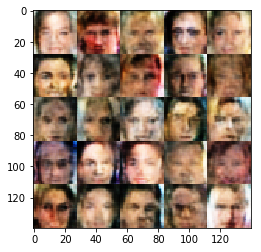

Epoch 1/1... Batch Count 2900... Discriminator Loss: 0.6731... Generator Loss: 1.4845
Epoch 1/1... Batch Count 2910... Discriminator Loss: 0.8265... Generator Loss: 2.2295
Epoch 1/1... Batch Count 2920... Discriminator Loss: 1.0022... Generator Loss: 0.9317
Epoch 1/1... Batch Count 2930... Discriminator Loss: 0.5639... Generator Loss: 2.1603
Epoch 1/1... Batch Count 2940... Discriminator Loss: 1.0512... Generator Loss: 1.4551
Epoch 1/1... Batch Count 2950... Discriminator Loss: 0.6640... Generator Loss: 1.5273
Epoch 1/1... Batch Count 2960... Discriminator Loss: 0.4814... Generator Loss: 3.9596
Epoch 1/1... Batch Count 2970... Discriminator Loss: 0.9945... Generator Loss: 0.8946
Epoch 1/1... Batch Count 2980... Discriminator Loss: 0.8947... Generator Loss: 3.3546
Epoch 1/1... Batch Count 2990... Discriminator Loss: 0.4736... Generator Loss: 2.6920


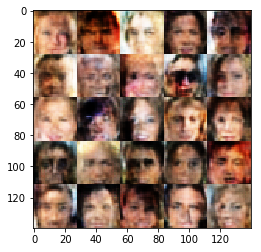

Epoch 1/1... Batch Count 3000... Discriminator Loss: 0.6402... Generator Loss: 3.2974
Epoch 1/1... Batch Count 3010... Discriminator Loss: 0.4644... Generator Loss: 2.5461
Epoch 1/1... Batch Count 3020... Discriminator Loss: 1.4340... Generator Loss: 0.5638
Epoch 1/1... Batch Count 3030... Discriminator Loss: 0.7074... Generator Loss: 1.5194
Epoch 1/1... Batch Count 3040... Discriminator Loss: 0.5617... Generator Loss: 1.9464
Epoch 1/1... Batch Count 3050... Discriminator Loss: 0.4439... Generator Loss: 3.5801
Epoch 1/1... Batch Count 3060... Discriminator Loss: 0.4386... Generator Loss: 2.9673
Epoch 1/1... Batch Count 3070... Discriminator Loss: 0.4710... Generator Loss: 2.6393
Epoch 1/1... Batch Count 3080... Discriminator Loss: 0.5244... Generator Loss: 2.1523
Epoch 1/1... Batch Count 3090... Discriminator Loss: 1.3378... Generator Loss: 0.6373


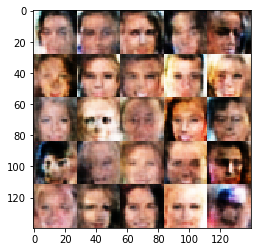

Epoch 1/1... Batch Count 3100... Discriminator Loss: 2.2548... Generator Loss: 0.2278
Epoch 1/1... Batch Count 3110... Discriminator Loss: 0.5587... Generator Loss: 2.0434
Epoch 1/1... Batch Count 3120... Discriminator Loss: 0.7541... Generator Loss: 1.2369
Epoch 1/1... Batch Count 3130... Discriminator Loss: 0.5409... Generator Loss: 2.3027
Epoch 1/1... Batch Count 3140... Discriminator Loss: 0.6145... Generator Loss: 1.8089
Epoch 1/1... Batch Count 3150... Discriminator Loss: 0.4919... Generator Loss: 2.7289
Epoch 1/1... Batch Count 3160... Discriminator Loss: 0.4301... Generator Loss: 2.9598
Epoch 1/1... Batch Count 3170... Discriminator Loss: 0.3900... Generator Loss: 3.4304
Epoch 1/1... Batch Count 3180... Discriminator Loss: 0.4652... Generator Loss: 2.3339
Epoch 1/1... Batch Count 3190... Discriminator Loss: 0.4529... Generator Loss: 2.5551


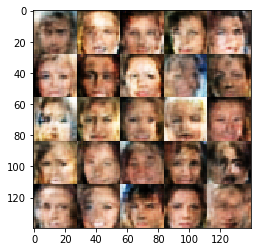

Epoch 1/1... Batch Count 3200... Discriminator Loss: 0.8761... Generator Loss: 1.0181
Epoch 1/1... Batch Count 3210... Discriminator Loss: 0.7984... Generator Loss: 1.2112
Epoch 1/1... Batch Count 3220... Discriminator Loss: 0.7326... Generator Loss: 1.3037
Epoch 1/1... Batch Count 3230... Discriminator Loss: 0.5086... Generator Loss: 2.9154
Epoch 1/1... Batch Count 3240... Discriminator Loss: 0.4691... Generator Loss: 2.9655
Epoch 1/1... Batch Count 3250... Discriminator Loss: 0.5370... Generator Loss: 2.0679
Epoch 1/1... Batch Count 3260... Discriminator Loss: 0.8331... Generator Loss: 1.1944
Epoch 1/1... Batch Count 3270... Discriminator Loss: 0.5643... Generator Loss: 2.8186
Epoch 1/1... Batch Count 3280... Discriminator Loss: 0.5576... Generator Loss: 2.5955
Epoch 1/1... Batch Count 3290... Discriminator Loss: 0.7311... Generator Loss: 3.2251


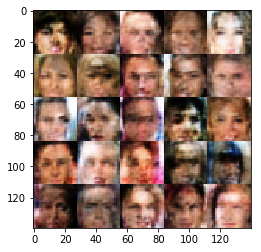

Epoch 1/1... Batch Count 3300... Discriminator Loss: 0.5571... Generator Loss: 4.0992
Epoch 1/1... Batch Count 3310... Discriminator Loss: 0.6984... Generator Loss: 2.6877
Epoch 1/1... Batch Count 3320... Discriminator Loss: 1.0355... Generator Loss: 2.9398
Epoch 1/1... Batch Count 3330... Discriminator Loss: 0.5598... Generator Loss: 3.4005
Epoch 1/1... Batch Count 3340... Discriminator Loss: 0.5579... Generator Loss: 2.4362
Epoch 1/1... Batch Count 3350... Discriminator Loss: 0.9334... Generator Loss: 2.6780
Epoch 1/1... Batch Count 3360... Discriminator Loss: 0.4942... Generator Loss: 2.3900
Epoch 1/1... Batch Count 3370... Discriminator Loss: 0.4507... Generator Loss: 2.4779
Epoch 1/1... Batch Count 3380... Discriminator Loss: 0.5417... Generator Loss: 3.7950
Epoch 1/1... Batch Count 3390... Discriminator Loss: 1.1217... Generator Loss: 0.7468


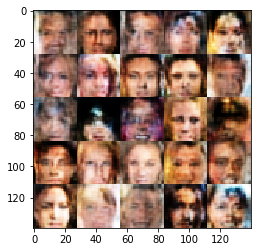

Epoch 1/1... Batch Count 3400... Discriminator Loss: 0.5548... Generator Loss: 2.2539
Epoch 1/1... Batch Count 3410... Discriminator Loss: 0.4536... Generator Loss: 3.0721
Epoch 1/1... Batch Count 3420... Discriminator Loss: 0.5842... Generator Loss: 2.3279
Epoch 1/1... Batch Count 3430... Discriminator Loss: 0.6715... Generator Loss: 1.5989
Epoch 1/1... Batch Count 3440... Discriminator Loss: 0.4372... Generator Loss: 2.6719
Epoch 1/1... Batch Count 3450... Discriminator Loss: 0.6579... Generator Loss: 1.6609
Epoch 1/1... Batch Count 3460... Discriminator Loss: 0.8269... Generator Loss: 2.3566
Epoch 1/1... Batch Count 3470... Discriminator Loss: 1.1752... Generator Loss: 1.8340
Epoch 1/1... Batch Count 3480... Discriminator Loss: 0.6480... Generator Loss: 1.7435
Epoch 1/1... Batch Count 3490... Discriminator Loss: 0.5027... Generator Loss: 2.9152


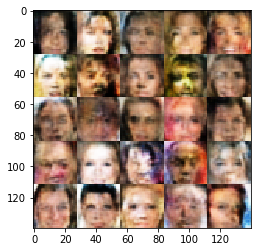

Epoch 1/1... Batch Count 3500... Discriminator Loss: 0.3554... Generator Loss: 5.0285
Epoch 1/1... Batch Count 3510... Discriminator Loss: 0.4692... Generator Loss: 2.4386
Epoch 1/1... Batch Count 3520... Discriminator Loss: 1.1586... Generator Loss: 2.6258
Epoch 1/1... Batch Count 3530... Discriminator Loss: 1.2316... Generator Loss: 0.7824
Epoch 1/1... Batch Count 3540... Discriminator Loss: 0.5896... Generator Loss: 1.9249
Epoch 1/1... Batch Count 3550... Discriminator Loss: 0.4864... Generator Loss: 4.2207
Epoch 1/1... Batch Count 3560... Discriminator Loss: 0.4889... Generator Loss: 2.9243
Epoch 1/1... Batch Count 3570... Discriminator Loss: 0.5789... Generator Loss: 2.3785
Epoch 1/1... Batch Count 3580... Discriminator Loss: 0.6690... Generator Loss: 1.4936
Epoch 1/1... Batch Count 3590... Discriminator Loss: 0.4644... Generator Loss: 2.8198


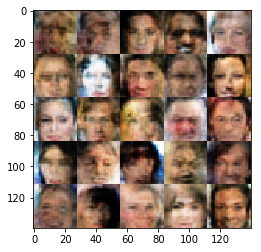

Epoch 1/1... Batch Count 3600... Discriminator Loss: 0.9138... Generator Loss: 2.9729
Epoch 1/1... Batch Count 3610... Discriminator Loss: 1.9610... Generator Loss: 0.3514
Epoch 1/1... Batch Count 3620... Discriminator Loss: 0.6273... Generator Loss: 2.0114
Epoch 1/1... Batch Count 3630... Discriminator Loss: 0.4215... Generator Loss: 3.0738
Epoch 1/1... Batch Count 3640... Discriminator Loss: 0.8719... Generator Loss: 1.3260
Epoch 1/1... Batch Count 3650... Discriminator Loss: 0.4576... Generator Loss: 3.1614
Epoch 1/1... Batch Count 3660... Discriminator Loss: 0.4546... Generator Loss: 2.5744
Epoch 1/1... Batch Count 3670... Discriminator Loss: 0.5168... Generator Loss: 2.4682
Epoch 1/1... Batch Count 3680... Discriminator Loss: 0.5172... Generator Loss: 2.1126
Epoch 1/1... Batch Count 3690... Discriminator Loss: 0.5655... Generator Loss: 1.8490


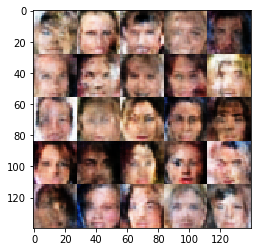

Epoch 1/1... Batch Count 3700... Discriminator Loss: 0.4488... Generator Loss: 4.6534
Epoch 1/1... Batch Count 3710... Discriminator Loss: 1.4518... Generator Loss: 0.6431
Epoch 1/1... Batch Count 3720... Discriminator Loss: 1.0270... Generator Loss: 2.4976
Epoch 1/1... Batch Count 3730... Discriminator Loss: 0.7280... Generator Loss: 1.4109
Epoch 1/1... Batch Count 3740... Discriminator Loss: 0.7334... Generator Loss: 1.9437
Epoch 1/1... Batch Count 3750... Discriminator Loss: 1.4706... Generator Loss: 2.3269
Epoch 1/1... Batch Count 3760... Discriminator Loss: 0.7869... Generator Loss: 3.9488
Epoch 1/1... Batch Count 3770... Discriminator Loss: 0.6381... Generator Loss: 2.1095
Epoch 1/1... Batch Count 3780... Discriminator Loss: 0.8212... Generator Loss: 2.2169
Epoch 1/1... Batch Count 3790... Discriminator Loss: 0.8334... Generator Loss: 2.8167


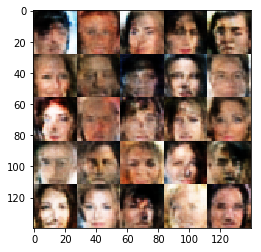

Epoch 1/1... Batch Count 3800... Discriminator Loss: 0.6719... Generator Loss: 1.6317
Epoch 1/1... Batch Count 3810... Discriminator Loss: 0.5635... Generator Loss: 1.9230
Epoch 1/1... Batch Count 3820... Discriminator Loss: 0.5334... Generator Loss: 2.1937
Epoch 1/1... Batch Count 3830... Discriminator Loss: 0.5227... Generator Loss: 1.9614
Epoch 1/1... Batch Count 3840... Discriminator Loss: 0.5527... Generator Loss: 2.4624
Epoch 1/1... Batch Count 3850... Discriminator Loss: 0.6638... Generator Loss: 1.6582
Epoch 1/1... Batch Count 3860... Discriminator Loss: 0.6262... Generator Loss: 2.4883
Epoch 1/1... Batch Count 3870... Discriminator Loss: 1.5134... Generator Loss: 0.4492
Epoch 1/1... Batch Count 3880... Discriminator Loss: 1.1057... Generator Loss: 1.2468
Epoch 1/1... Batch Count 3890... Discriminator Loss: 0.5815... Generator Loss: 2.3150


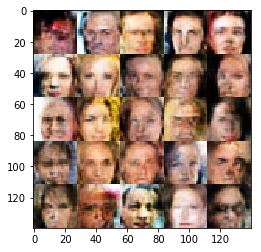

Epoch 1/1... Batch Count 3900... Discriminator Loss: 1.2829... Generator Loss: 3.5616
Epoch 1/1... Batch Count 3910... Discriminator Loss: 1.3497... Generator Loss: 0.7439
Epoch 1/1... Batch Count 3920... Discriminator Loss: 0.7129... Generator Loss: 1.4937
Epoch 1/1... Batch Count 3930... Discriminator Loss: 0.5748... Generator Loss: 1.8530
Epoch 1/1... Batch Count 3940... Discriminator Loss: 1.6641... Generator Loss: 0.3793
Epoch 1/1... Batch Count 3950... Discriminator Loss: 0.5254... Generator Loss: 3.3871
Epoch 1/1... Batch Count 3960... Discriminator Loss: 0.4483... Generator Loss: 3.0734
Epoch 1/1... Batch Count 3970... Discriminator Loss: 0.8336... Generator Loss: 1.7068
Epoch 1/1... Batch Count 3980... Discriminator Loss: 0.8265... Generator Loss: 1.1912
Epoch 1/1... Batch Count 3990... Discriminator Loss: 0.5503... Generator Loss: 2.0325


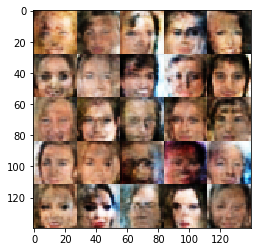

Epoch 1/1... Batch Count 4000... Discriminator Loss: 0.5248... Generator Loss: 2.0311
Epoch 1/1... Batch Count 4010... Discriminator Loss: 0.9184... Generator Loss: 1.1361
Epoch 1/1... Batch Count 4020... Discriminator Loss: 0.8471... Generator Loss: 1.1167
Epoch 1/1... Batch Count 4030... Discriminator Loss: 0.7393... Generator Loss: 1.4099
Epoch 1/1... Batch Count 4040... Discriminator Loss: 0.5283... Generator Loss: 2.1235
Epoch 1/1... Batch Count 4050... Discriminator Loss: 1.6520... Generator Loss: 0.5127
Epoch 1/1... Batch Count 4060... Discriminator Loss: 0.8024... Generator Loss: 1.2632
Epoch 1/1... Batch Count 4070... Discriminator Loss: 0.4113... Generator Loss: 4.0763
Epoch 1/1... Batch Count 4080... Discriminator Loss: 1.6344... Generator Loss: 3.8265
Epoch 1/1... Batch Count 4090... Discriminator Loss: 0.4090... Generator Loss: 3.1391


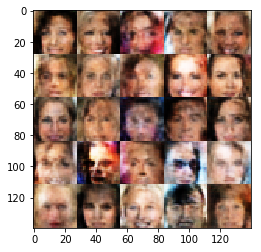

Epoch 1/1... Batch Count 4100... Discriminator Loss: 0.6303... Generator Loss: 1.6257
Epoch 1/1... Batch Count 4110... Discriminator Loss: 0.7302... Generator Loss: 1.4271
Epoch 1/1... Batch Count 4120... Discriminator Loss: 0.4318... Generator Loss: 3.1518
Epoch 1/1... Batch Count 4130... Discriminator Loss: 1.0236... Generator Loss: 2.0834
Epoch 1/1... Batch Count 4140... Discriminator Loss: 0.4642... Generator Loss: 2.4662
Epoch 1/1... Batch Count 4150... Discriminator Loss: 0.4286... Generator Loss: 5.3953
Epoch 1/1... Batch Count 4160... Discriminator Loss: 0.6434... Generator Loss: 1.7417
Epoch 1/1... Batch Count 4170... Discriminator Loss: 0.4546... Generator Loss: 2.3861
Epoch 1/1... Batch Count 4180... Discriminator Loss: 0.6974... Generator Loss: 2.1591
Epoch 1/1... Batch Count 4190... Discriminator Loss: 0.3709... Generator Loss: 4.1587


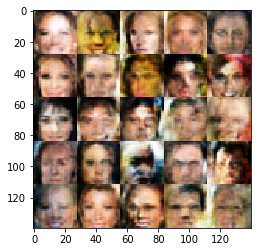

Epoch 1/1... Batch Count 4200... Discriminator Loss: 0.7477... Generator Loss: 2.9337
Epoch 1/1... Batch Count 4210... Discriminator Loss: 0.7898... Generator Loss: 2.8088
Epoch 1/1... Batch Count 4220... Discriminator Loss: 0.7560... Generator Loss: 1.3113
Epoch 1/1... Batch Count 4230... Discriminator Loss: 0.3559... Generator Loss: 4.6185
Epoch 1/1... Batch Count 4240... Discriminator Loss: 0.9874... Generator Loss: 0.9031
Epoch 1/1... Batch Count 4250... Discriminator Loss: 0.4252... Generator Loss: 3.2045
Epoch 1/1... Batch Count 4260... Discriminator Loss: 0.4690... Generator Loss: 2.4102
Epoch 1/1... Batch Count 4270... Discriminator Loss: 0.4762... Generator Loss: 2.2785
Epoch 1/1... Batch Count 4280... Discriminator Loss: 0.5438... Generator Loss: 2.9859
Epoch 1/1... Batch Count 4290... Discriminator Loss: 0.6171... Generator Loss: 1.7264


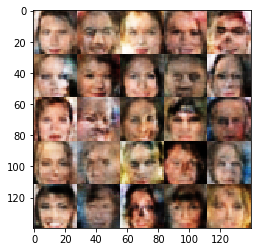

Epoch 1/1... Batch Count 4300... Discriminator Loss: 0.7595... Generator Loss: 1.5260
Epoch 1/1... Batch Count 4310... Discriminator Loss: 1.7911... Generator Loss: 0.3770
Epoch 1/1... Batch Count 4320... Discriminator Loss: 0.5859... Generator Loss: 1.8484
Epoch 1/1... Batch Count 4330... Discriminator Loss: 0.4879... Generator Loss: 2.4889
Epoch 1/1... Batch Count 4340... Discriminator Loss: 0.6736... Generator Loss: 1.5045
Epoch 1/1... Batch Count 4350... Discriminator Loss: 0.4773... Generator Loss: 2.8898
Epoch 1/1... Batch Count 4360... Discriminator Loss: 0.3905... Generator Loss: 3.5836
Epoch 1/1... Batch Count 4370... Discriminator Loss: 0.6325... Generator Loss: 1.8013
Epoch 1/1... Batch Count 4380... Discriminator Loss: 0.4364... Generator Loss: 2.8991
Epoch 1/1... Batch Count 4390... Discriminator Loss: 0.6002... Generator Loss: 1.7379


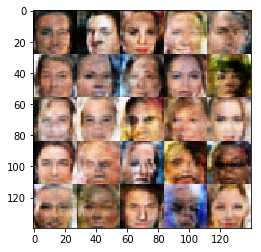

Epoch 1/1... Batch Count 4400... Discriminator Loss: 0.5226... Generator Loss: 3.6778
Epoch 1/1... Batch Count 4410... Discriminator Loss: 0.3517... Generator Loss: 4.9462
Epoch 1/1... Batch Count 4420... Discriminator Loss: 0.9064... Generator Loss: 1.1115
Epoch 1/1... Batch Count 4430... Discriminator Loss: 0.7370... Generator Loss: 4.9169
Epoch 1/1... Batch Count 4440... Discriminator Loss: 0.4356... Generator Loss: 3.0247
Epoch 1/1... Batch Count 4450... Discriminator Loss: 0.8050... Generator Loss: 1.2370
Epoch 1/1... Batch Count 4460... Discriminator Loss: 0.5330... Generator Loss: 2.9815
Epoch 1/1... Batch Count 4470... Discriminator Loss: 0.4770... Generator Loss: 2.3267
Epoch 1/1... Batch Count 4480... Discriminator Loss: 0.4656... Generator Loss: 3.4069
Epoch 1/1... Batch Count 4490... Discriminator Loss: 0.4962... Generator Loss: 2.3316


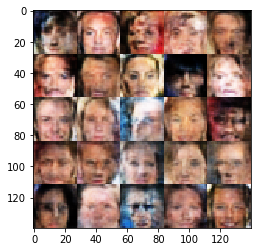

Epoch 1/1... Batch Count 4500... Discriminator Loss: 0.3812... Generator Loss: 4.0466
Epoch 1/1... Batch Count 4510... Discriminator Loss: 0.5420... Generator Loss: 2.1952
Epoch 1/1... Batch Count 4520... Discriminator Loss: 1.4653... Generator Loss: 0.6756
Epoch 1/1... Batch Count 4530... Discriminator Loss: 0.7192... Generator Loss: 1.6160
Epoch 1/1... Batch Count 4540... Discriminator Loss: 0.8086... Generator Loss: 3.3549
Epoch 1/1... Batch Count 4550... Discriminator Loss: 1.1979... Generator Loss: 0.7193
Epoch 1/1... Batch Count 4560... Discriminator Loss: 0.8067... Generator Loss: 1.2806
Epoch 1/1... Batch Count 4570... Discriminator Loss: 0.4142... Generator Loss: 3.4178
Epoch 1/1... Batch Count 4580... Discriminator Loss: 0.7998... Generator Loss: 1.2387
Epoch 1/1... Batch Count 4590... Discriminator Loss: 0.5866... Generator Loss: 1.7982


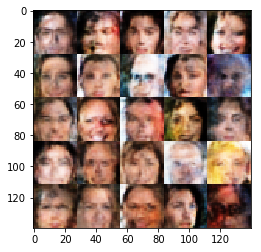

Epoch 1/1... Batch Count 4600... Discriminator Loss: 1.2045... Generator Loss: 0.9339
Epoch 1/1... Batch Count 4610... Discriminator Loss: 1.1969... Generator Loss: 2.6720
Epoch 1/1... Batch Count 4620... Discriminator Loss: 0.6744... Generator Loss: 1.6769
Epoch 1/1... Batch Count 4630... Discriminator Loss: 0.5387... Generator Loss: 1.9905
Epoch 1/1... Batch Count 4640... Discriminator Loss: 0.4382... Generator Loss: 2.9531
Epoch 1/1... Batch Count 4650... Discriminator Loss: 0.4629... Generator Loss: 2.9657
Epoch 1/1... Batch Count 4660... Discriminator Loss: 0.4615... Generator Loss: 2.8376
Epoch 1/1... Batch Count 4670... Discriminator Loss: 0.7205... Generator Loss: 4.6455
Epoch 1/1... Batch Count 4680... Discriminator Loss: 0.6522... Generator Loss: 1.8861
Epoch 1/1... Batch Count 4690... Discriminator Loss: 0.6905... Generator Loss: 1.4621


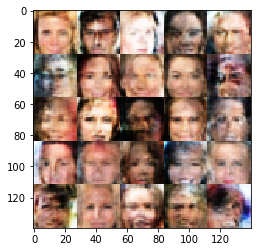

Epoch 1/1... Batch Count 4700... Discriminator Loss: 0.5382... Generator Loss: 2.9638
Epoch 1/1... Batch Count 4710... Discriminator Loss: 0.4737... Generator Loss: 2.4000
Epoch 1/1... Batch Count 4720... Discriminator Loss: 0.5903... Generator Loss: 1.7124
Epoch 1/1... Batch Count 4730... Discriminator Loss: 3.3882... Generator Loss: 0.1074
Epoch 1/1... Batch Count 4740... Discriminator Loss: 0.8287... Generator Loss: 1.2103
Epoch 1/1... Batch Count 4750... Discriminator Loss: 0.5593... Generator Loss: 2.3044
Epoch 1/1... Batch Count 4760... Discriminator Loss: 0.9308... Generator Loss: 2.7475
Epoch 1/1... Batch Count 4770... Discriminator Loss: 1.1760... Generator Loss: 1.1616
Epoch 1/1... Batch Count 4780... Discriminator Loss: 0.7464... Generator Loss: 1.3559
Epoch 1/1... Batch Count 4790... Discriminator Loss: 0.4974... Generator Loss: 2.3933


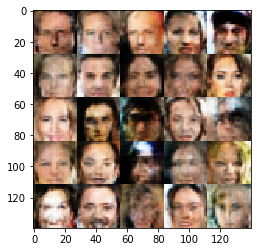

Epoch 1/1... Batch Count 4800... Discriminator Loss: 0.5471... Generator Loss: 1.9695
Epoch 1/1... Batch Count 4810... Discriminator Loss: 0.4548... Generator Loss: 2.6993
Epoch 1/1... Batch Count 4820... Discriminator Loss: 0.4902... Generator Loss: 2.8919
Epoch 1/1... Batch Count 4830... Discriminator Loss: 0.7683... Generator Loss: 1.3541
Epoch 1/1... Batch Count 4840... Discriminator Loss: 1.3244... Generator Loss: 0.6422
Epoch 1/1... Batch Count 4850... Discriminator Loss: 0.5947... Generator Loss: 1.8774
Epoch 1/1... Batch Count 4860... Discriminator Loss: 0.6620... Generator Loss: 1.5705
Epoch 1/1... Batch Count 4870... Discriminator Loss: 0.7293... Generator Loss: 1.3531
Epoch 1/1... Batch Count 4880... Discriminator Loss: 0.5895... Generator Loss: 1.8877
Epoch 1/1... Batch Count 4890... Discriminator Loss: 0.6132... Generator Loss: 1.7956


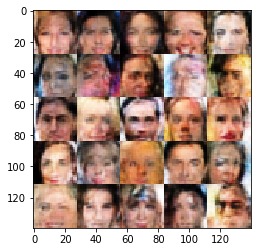

Epoch 1/1... Batch Count 4900... Discriminator Loss: 0.5038... Generator Loss: 3.1059
Epoch 1/1... Batch Count 4910... Discriminator Loss: 0.5531... Generator Loss: 1.9939
Epoch 1/1... Batch Count 4920... Discriminator Loss: 0.7000... Generator Loss: 1.4643
Epoch 1/1... Batch Count 4930... Discriminator Loss: 1.0813... Generator Loss: 1.0557
Epoch 1/1... Batch Count 4940... Discriminator Loss: 0.6467... Generator Loss: 1.9385
Epoch 1/1... Batch Count 4950... Discriminator Loss: 0.6352... Generator Loss: 1.6521
Epoch 1/1... Batch Count 4960... Discriminator Loss: 0.6250... Generator Loss: 1.7448
Epoch 1/1... Batch Count 4970... Discriminator Loss: 0.4079... Generator Loss: 3.7885
Epoch 1/1... Batch Count 4980... Discriminator Loss: 0.7606... Generator Loss: 1.3541
Epoch 1/1... Batch Count 4990... Discriminator Loss: 0.4870... Generator Loss: 2.3774


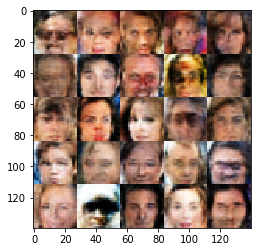

Epoch 1/1... Batch Count 5000... Discriminator Loss: 0.3773... Generator Loss: 4.0033
Epoch 1/1... Batch Count 5010... Discriminator Loss: 0.8172... Generator Loss: 1.1821
Epoch 1/1... Batch Count 5020... Discriminator Loss: 0.4298... Generator Loss: 2.8199
Epoch 1/1... Batch Count 5030... Discriminator Loss: 0.7424... Generator Loss: 1.2593
Epoch 1/1... Batch Count 5040... Discriminator Loss: 0.7194... Generator Loss: 2.1089
Epoch 1/1... Batch Count 5050... Discriminator Loss: 0.8267... Generator Loss: 1.3469
Epoch 1/1... Batch Count 5060... Discriminator Loss: 0.6037... Generator Loss: 1.7097
Epoch 1/1... Batch Count 5070... Discriminator Loss: 0.6592... Generator Loss: 1.5437
Epoch 1/1... Batch Count 5080... Discriminator Loss: 0.6699... Generator Loss: 3.4067
Epoch 1/1... Batch Count 5090... Discriminator Loss: 0.8613... Generator Loss: 1.2865


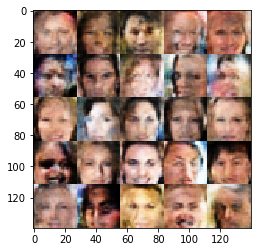

Epoch 1/1... Batch Count 5100... Discriminator Loss: 0.5204... Generator Loss: 2.2938
Epoch 1/1... Batch Count 5110... Discriminator Loss: 0.5042... Generator Loss: 2.7482
Epoch 1/1... Batch Count 5120... Discriminator Loss: 0.5824... Generator Loss: 1.8547
Epoch 1/1... Batch Count 5130... Discriminator Loss: 0.8825... Generator Loss: 1.3661
Epoch 1/1... Batch Count 5140... Discriminator Loss: 2.2036... Generator Loss: 0.2791
Epoch 1/1... Batch Count 5150... Discriminator Loss: 0.6281... Generator Loss: 2.0473
Epoch 1/1... Batch Count 5160... Discriminator Loss: 0.6932... Generator Loss: 2.0669
Epoch 1/1... Batch Count 5170... Discriminator Loss: 0.7308... Generator Loss: 1.3699
Epoch 1/1... Batch Count 5180... Discriminator Loss: 0.5597... Generator Loss: 2.0453
Epoch 1/1... Batch Count 5190... Discriminator Loss: 0.9568... Generator Loss: 0.9723


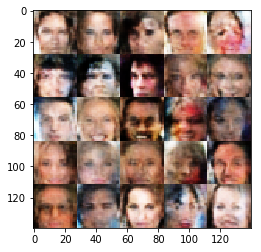

Epoch 1/1... Batch Count 5200... Discriminator Loss: 0.7718... Generator Loss: 1.2912
Epoch 1/1... Batch Count 5210... Discriminator Loss: 0.6261... Generator Loss: 1.7243
Epoch 1/1... Batch Count 5220... Discriminator Loss: 0.4393... Generator Loss: 3.5595
Epoch 1/1... Batch Count 5230... Discriminator Loss: 0.8728... Generator Loss: 1.0280
Epoch 1/1... Batch Count 5240... Discriminator Loss: 1.1684... Generator Loss: 0.7749
Epoch 1/1... Batch Count 5250... Discriminator Loss: 0.6224... Generator Loss: 1.7595
Epoch 1/1... Batch Count 5260... Discriminator Loss: 0.7012... Generator Loss: 1.4922
Epoch 1/1... Batch Count 5270... Discriminator Loss: 0.8046... Generator Loss: 2.1897
Epoch 1/1... Batch Count 5280... Discriminator Loss: 0.9066... Generator Loss: 1.1170
Epoch 1/1... Batch Count 5290... Discriminator Loss: 0.5599... Generator Loss: 1.9686


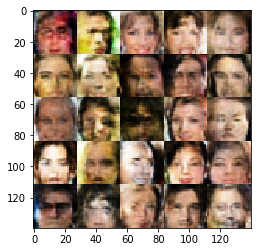

Epoch 1/1... Batch Count 5300... Discriminator Loss: 0.6040... Generator Loss: 1.6576
Epoch 1/1... Batch Count 5310... Discriminator Loss: 0.6652... Generator Loss: 1.5287
Epoch 1/1... Batch Count 5320... Discriminator Loss: 0.3761... Generator Loss: 5.3294
Epoch 1/1... Batch Count 5330... Discriminator Loss: 1.9044... Generator Loss: 0.3859
Epoch 1/1... Batch Count 5340... Discriminator Loss: 0.5941... Generator Loss: 2.3989
Epoch 1/1... Batch Count 5350... Discriminator Loss: 0.4266... Generator Loss: 3.3585
Epoch 1/1... Batch Count 5360... Discriminator Loss: 0.4110... Generator Loss: 3.0074
Epoch 1/1... Batch Count 5370... Discriminator Loss: 0.4435... Generator Loss: 3.0427
Epoch 1/1... Batch Count 5380... Discriminator Loss: 0.5323... Generator Loss: 2.1227
Epoch 1/1... Batch Count 5390... Discriminator Loss: 0.4388... Generator Loss: 3.1230


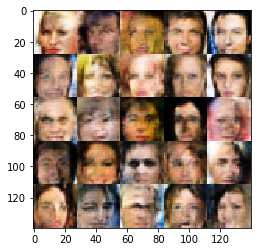

Epoch 1/1... Batch Count 5400... Discriminator Loss: 0.5321... Generator Loss: 2.4117
Epoch 1/1... Batch Count 5410... Discriminator Loss: 0.6798... Generator Loss: 1.5709
Epoch 1/1... Batch Count 5420... Discriminator Loss: 0.5337... Generator Loss: 2.6033
Epoch 1/1... Batch Count 5430... Discriminator Loss: 1.4333... Generator Loss: 3.0538
Epoch 1/1... Batch Count 5440... Discriminator Loss: 0.8421... Generator Loss: 1.3539
Epoch 1/1... Batch Count 5450... Discriminator Loss: 0.8916... Generator Loss: 1.2205
Epoch 1/1... Batch Count 5460... Discriminator Loss: 0.9888... Generator Loss: 1.0345
Epoch 1/1... Batch Count 5470... Discriminator Loss: 0.8877... Generator Loss: 1.0732
Epoch 1/1... Batch Count 5480... Discriminator Loss: 0.6912... Generator Loss: 2.9436
Epoch 1/1... Batch Count 5490... Discriminator Loss: 1.1533... Generator Loss: 0.9201


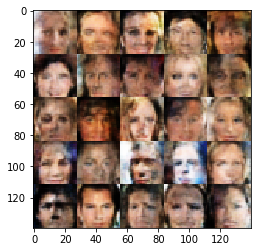

Epoch 1/1... Batch Count 5500... Discriminator Loss: 0.9309... Generator Loss: 1.0141
Epoch 1/1... Batch Count 5510... Discriminator Loss: 0.5667... Generator Loss: 1.9067
Epoch 1/1... Batch Count 5520... Discriminator Loss: 0.5306... Generator Loss: 2.1423
Epoch 1/1... Batch Count 5530... Discriminator Loss: 0.6968... Generator Loss: 1.4739
Epoch 1/1... Batch Count 5540... Discriminator Loss: 0.9148... Generator Loss: 1.0932
Epoch 1/1... Batch Count 5550... Discriminator Loss: 1.1918... Generator Loss: 1.1179
Epoch 1/1... Batch Count 5560... Discriminator Loss: 0.5457... Generator Loss: 2.0819
Epoch 1/1... Batch Count 5570... Discriminator Loss: 0.7991... Generator Loss: 2.4259
Epoch 1/1... Batch Count 5580... Discriminator Loss: 0.6758... Generator Loss: 1.4815
Epoch 1/1... Batch Count 5590... Discriminator Loss: 0.4676... Generator Loss: 2.4493


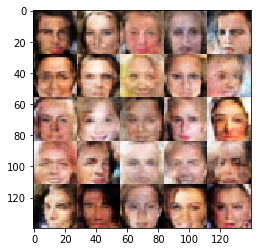

Epoch 1/1... Batch Count 5600... Discriminator Loss: 0.5229... Generator Loss: 2.1714
Epoch 1/1... Batch Count 5610... Discriminator Loss: 0.7706... Generator Loss: 1.2432
Epoch 1/1... Batch Count 5620... Discriminator Loss: 1.0775... Generator Loss: 0.9286
Epoch 1/1... Batch Count 5630... Discriminator Loss: 0.5538... Generator Loss: 2.0433
Epoch 1/1... Batch Count 5640... Discriminator Loss: 0.4872... Generator Loss: 2.8199
Epoch 1/1... Batch Count 5650... Discriminator Loss: 0.4030... Generator Loss: 3.7728
Epoch 1/1... Batch Count 5660... Discriminator Loss: 0.4111... Generator Loss: 5.1370
Epoch 1/1... Batch Count 5670... Discriminator Loss: 0.3834... Generator Loss: 3.8240
Epoch 1/1... Batch Count 5680... Discriminator Loss: 0.5378... Generator Loss: 2.0960
Epoch 1/1... Batch Count 5690... Discriminator Loss: 0.4041... Generator Loss: 2.9677


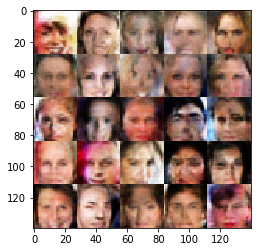

Epoch 1/1... Batch Count 5700... Discriminator Loss: 0.3863... Generator Loss: 3.5035
Epoch 1/1... Batch Count 5710... Discriminator Loss: 0.8830... Generator Loss: 2.4264
Epoch 1/1... Batch Count 5720... Discriminator Loss: 0.7646... Generator Loss: 1.3681
Epoch 1/1... Batch Count 5730... Discriminator Loss: 0.7157... Generator Loss: 1.7193
Epoch 1/1... Batch Count 5740... Discriminator Loss: 0.4032... Generator Loss: 3.1505
Epoch 1/1... Batch Count 5750... Discriminator Loss: 1.4810... Generator Loss: 0.5594
Epoch 1/1... Batch Count 5760... Discriminator Loss: 0.3990... Generator Loss: 3.4017
Epoch 1/1... Batch Count 5770... Discriminator Loss: 1.9252... Generator Loss: 0.3862
Epoch 1/1... Batch Count 5780... Discriminator Loss: 0.6977... Generator Loss: 2.1414
Epoch 1/1... Batch Count 5790... Discriminator Loss: 0.9421... Generator Loss: 1.0473


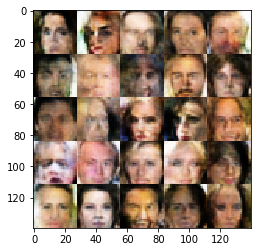

Epoch 1/1... Batch Count 5800... Discriminator Loss: 1.0911... Generator Loss: 0.9342
Epoch 1/1... Batch Count 5810... Discriminator Loss: 0.6696... Generator Loss: 1.8598
Epoch 1/1... Batch Count 5820... Discriminator Loss: 0.6847... Generator Loss: 1.5239
Epoch 1/1... Batch Count 5830... Discriminator Loss: 0.4732... Generator Loss: 2.8151
Epoch 1/1... Batch Count 5840... Discriminator Loss: 0.5358... Generator Loss: 2.0407
Epoch 1/1... Batch Count 5850... Discriminator Loss: 0.4814... Generator Loss: 2.3542
Epoch 1/1... Batch Count 5860... Discriminator Loss: 0.4366... Generator Loss: 3.4108
Epoch 1/1... Batch Count 5870... Discriminator Loss: 0.6008... Generator Loss: 3.2046
Epoch 1/1... Batch Count 5880... Discriminator Loss: 0.8431... Generator Loss: 1.1240
Epoch 1/1... Batch Count 5890... Discriminator Loss: 0.4469... Generator Loss: 5.6280


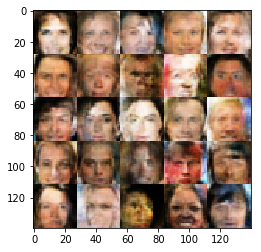

Epoch 1/1... Batch Count 5900... Discriminator Loss: 0.5025... Generator Loss: 2.7601
Epoch 1/1... Batch Count 5910... Discriminator Loss: 0.3715... Generator Loss: 4.0209
Epoch 1/1... Batch Count 5920... Discriminator Loss: 0.6037... Generator Loss: 1.7830
Epoch 1/1... Batch Count 5930... Discriminator Loss: 0.6653... Generator Loss: 2.6483
Epoch 1/1... Batch Count 5940... Discriminator Loss: 0.4641... Generator Loss: 4.5560
Epoch 1/1... Batch Count 5950... Discriminator Loss: 0.8119... Generator Loss: 1.8887
Epoch 1/1... Batch Count 5960... Discriminator Loss: 0.7173... Generator Loss: 1.5432
Epoch 1/1... Batch Count 5970... Discriminator Loss: 0.4379... Generator Loss: 2.7782
Epoch 1/1... Batch Count 5980... Discriminator Loss: 0.4923... Generator Loss: 2.3073
Epoch 1/1... Batch Count 5990... Discriminator Loss: 0.6131... Generator Loss: 1.7025


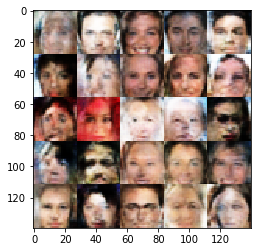

Epoch 1/1... Batch Count 6000... Discriminator Loss: 0.5879... Generator Loss: 2.0741
Epoch 1/1... Batch Count 6010... Discriminator Loss: 0.4708... Generator Loss: 2.7454
Epoch 1/1... Batch Count 6020... Discriminator Loss: 0.5315... Generator Loss: 2.1237
Epoch 1/1... Batch Count 6030... Discriminator Loss: 0.3778... Generator Loss: 4.6189
Epoch 1/1... Batch Count 6040... Discriminator Loss: 1.1495... Generator Loss: 1.0709
Epoch 1/1... Batch Count 6050... Discriminator Loss: 0.9696... Generator Loss: 2.1633
Epoch 1/1... Batch Count 6060... Discriminator Loss: 0.6854... Generator Loss: 1.6547
Epoch 1/1... Batch Count 6070... Discriminator Loss: 0.4116... Generator Loss: 3.4474
Epoch 1/1... Batch Count 6080... Discriminator Loss: 0.9725... Generator Loss: 0.9530
Epoch 1/1... Batch Count 6090... Discriminator Loss: 0.6933... Generator Loss: 1.8356


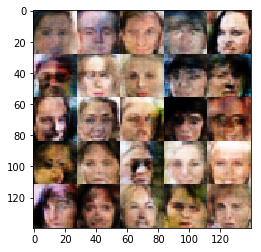

Epoch 1/1... Batch Count 6100... Discriminator Loss: 0.7780... Generator Loss: 1.4015
Epoch 1/1... Batch Count 6110... Discriminator Loss: 1.6357... Generator Loss: 0.5920
Epoch 1/1... Batch Count 6120... Discriminator Loss: 1.2840... Generator Loss: 0.7354
Epoch 1/1... Batch Count 6130... Discriminator Loss: 0.3538... Generator Loss: 4.7911
Epoch 1/1... Batch Count 6140... Discriminator Loss: 0.4436... Generator Loss: 3.2792
Epoch 1/1... Batch Count 6150... Discriminator Loss: 0.4867... Generator Loss: 2.4917
Epoch 1/1... Batch Count 6160... Discriminator Loss: 0.4010... Generator Loss: 4.5030
Epoch 1/1... Batch Count 6170... Discriminator Loss: 0.3926... Generator Loss: 4.3859
Epoch 1/1... Batch Count 6180... Discriminator Loss: 0.7252... Generator Loss: 1.4336
Epoch 1/1... Batch Count 6190... Discriminator Loss: 0.5578... Generator Loss: 1.9952


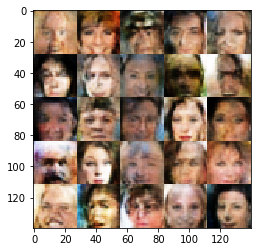

Epoch 1/1... Batch Count 6200... Discriminator Loss: 0.6082... Generator Loss: 1.7021
Epoch 1/1... Batch Count 6210... Discriminator Loss: 1.8786... Generator Loss: 0.4220
Epoch 1/1... Batch Count 6220... Discriminator Loss: 1.0003... Generator Loss: 1.0963
Epoch 1/1... Batch Count 6230... Discriminator Loss: 1.5378... Generator Loss: 0.5705
Epoch 1/1... Batch Count 6240... Discriminator Loss: 0.5781... Generator Loss: 2.0196
Epoch 1/1... Batch Count 6250... Discriminator Loss: 0.6946... Generator Loss: 1.4165
Epoch 1/1... Batch Count 6260... Discriminator Loss: 0.8923... Generator Loss: 2.0205
Epoch 1/1... Batch Count 6270... Discriminator Loss: 1.0188... Generator Loss: 0.9951
Epoch 1/1... Batch Count 6280... Discriminator Loss: 0.4401... Generator Loss: 3.2820
Epoch 1/1... Batch Count 6290... Discriminator Loss: 0.9537... Generator Loss: 1.0743


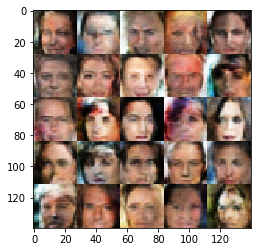

Epoch 1/1... Batch Count 6300... Discriminator Loss: 0.9138... Generator Loss: 1.4918
Epoch 1/1... Batch Count 6310... Discriminator Loss: 0.9411... Generator Loss: 3.1158
Epoch 1/1... Batch Count 6320... Discriminator Loss: 0.4870... Generator Loss: 3.0927
Epoch 1/1... Batch Count 6330... Discriminator Loss: 0.8776... Generator Loss: 1.2038


In [22]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.